# Import all the libraries and packages 

In [133]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm

# Get the path of all the data

In [134]:

filename_a = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp131.pkl'
filename_b = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp133.pkl'
filename_c = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp136.pkl'

# Load and get the data

In [135]:
with open(filename_a, 'rb') as myfile:
    a= joblib.load(myfile)

# Description about Hyperspectral data
## Data is obtained by scannig the core data from different boreholes using hyperspectral sensors. There were around 450 channels for each pixels initially. It was preprocessed and seperated based on 10 different types of rocks. In each of the file we have "X", "Y", "Z" coordinates points corresponding to sensors and corresponding to each rock type we have a transformed RGB correspondence information. 

(235,)
(234,)


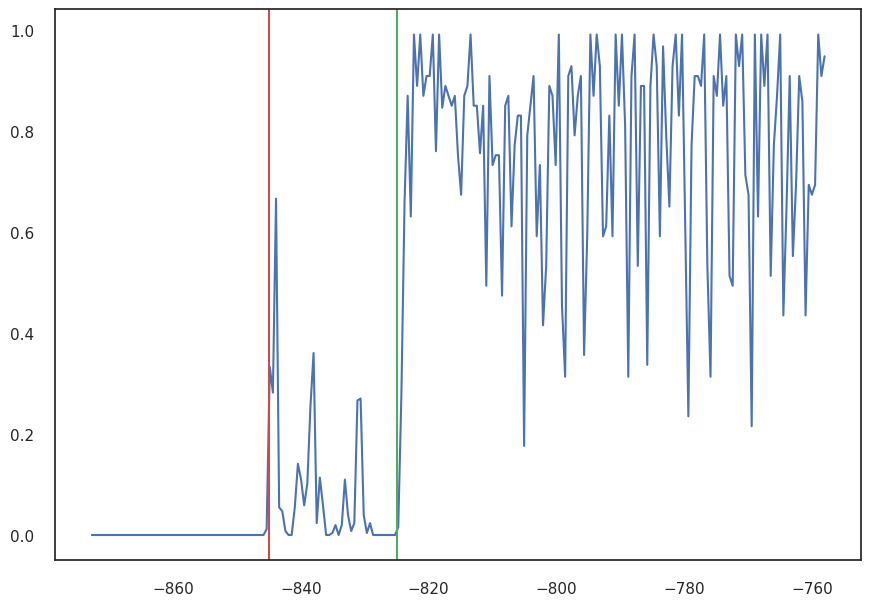

In [136]:
# The variability in "X" and "Y" are much smaller as compared to "Z" direction in case of birehole information. 
# Therefore, we are trying to build our model considering the "Z" direction mostly. 
# get the z-cordinates of borehole
zz = a['XYZ'][:,2]
print(zz.shape)
# sort the z-cordinates
ixx = np.argsort( zz )
# mask if values is less than some specified value
mask = zz[ixx] < -700
ah = a['BR_Anhydrite'][:,0] # correlates to "anhydrite index" derived from hyperspectral 
position_cord , hsi_data = zz[ixx][mask], ah[ixx][mask]/255 # To normalize the hyperspectral spectra, divide it with 255. 
plt.plot( position_cord , hsi_data )
print(position_cord.shape)

# define breakpoints 
# In general it is very difficult to define the breakpoints in the plot. Prepocessing of hyperspectral data is itself a very difficult task
# becasue of high correaltion, high dimensional and noisy data. 
brk1 = -845 
brk2 = -825 

plt.axvline( brk1, color='r' )
plt.axvline( brk2, color='g')

In [137]:
hsi_data.reshape(1,-1)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01176471, 0.33333333, 0.28235294, 0.66666667,
        0.05490196, 0.04705882, 0.00784314, 0.        , 0.        ,
        0.05490196, 0.14117647, 0.10980392, 0.05882353, 0.10196078,
        0.25490196, 0.36078431, 0.02352941, 0.11

# Since it is difficult to classify a hyperspectral data in general. We can apply different classical clustering methods to have some starting guess

In [138]:

X = np.concatenate(((position_cord.reshape((-1,1))/1000.0), hsi_data.reshape((-1,1))), axis=1)


In [139]:
#gm2 = BayesianGaussianMixture(n_components=3,covariance_type="full", random_state=0).fit(hsi_data.reshape(-1,1))
gm2 = BayesianGaussianMixture(n_components=3,covariance_type="full", random_state=0).fit(X)
gm2.means_ , gm2.covariances_

(array([[-0.79129305,  0.494441  ],
        [-0.84909215,  0.01754853],
        [-0.79521703,  0.87787907]]),
 array([[[0.00063178, 0.00251908],
         [0.00251908, 0.03378569]],
 
        [[0.00022452, 0.00043622],
         [0.00043622, 0.00486684]],
 
        [[0.00039097, 0.00084857],
         [0.00084857, 0.01155452]]]))

In [140]:
loc_mean = torch.tensor(gm2.means_)
loc_cov  = torch.tensor(gm2.covariances_)

In [141]:
correct_order = [0,2,1]
loc_mean, loc_cov = loc_mean[correct_order], loc_cov[correct_order]

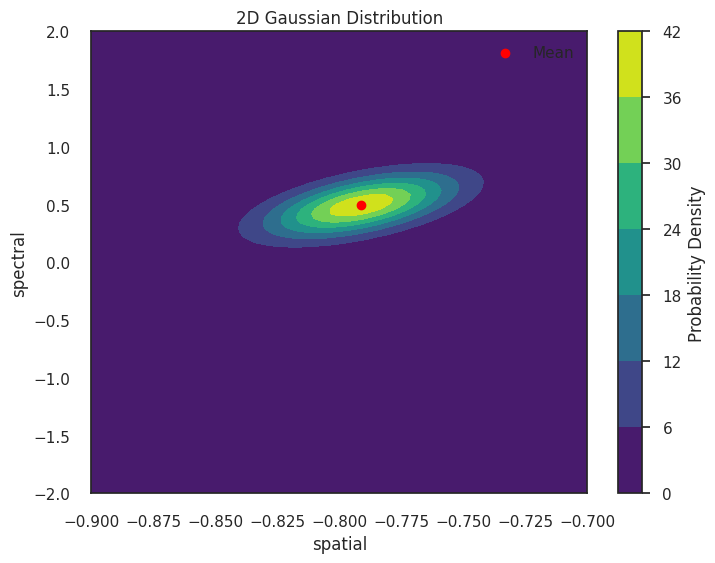

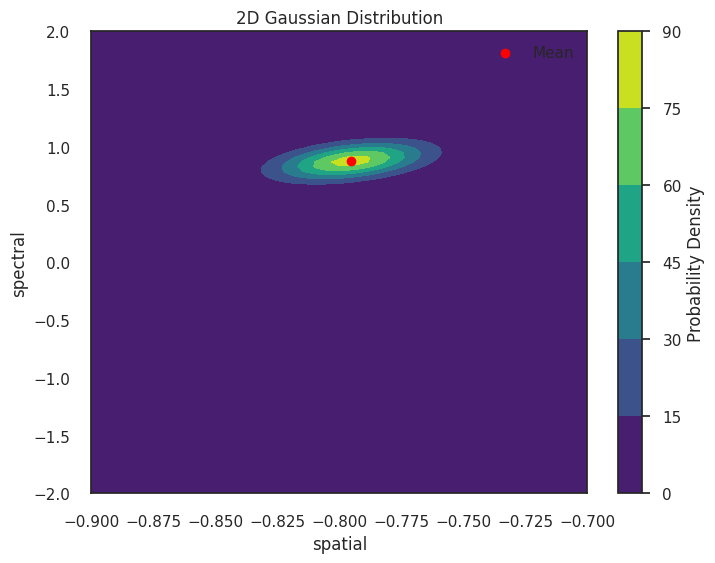

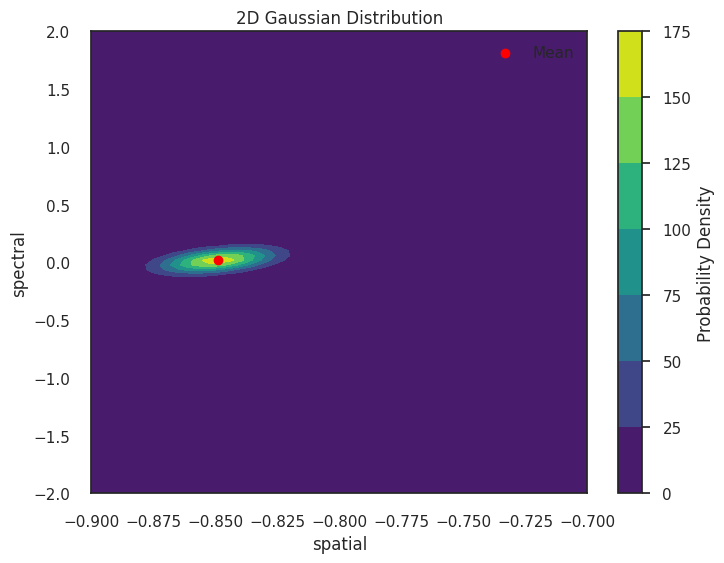

In [142]:
from scipy.stats import multivariate_normal

# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 100), np.linspace(-2, 2, 100))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = multivariate_normal(loc_mean[i], loc_cov[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)

    # Plot the Gaussian distribution using contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, pdf_values, cmap='viridis')
    plt.colorbar(label='Probability Density')
    plt.xlabel('spatial')
    plt.ylabel('spectral')
    plt.title('2D Gaussian Distribution')
    plt.scatter(loc_mean[i][0], loc_mean[i][1], color='red', label='Mean')
    plt.legend()
    plt.grid(True)
plt.show()

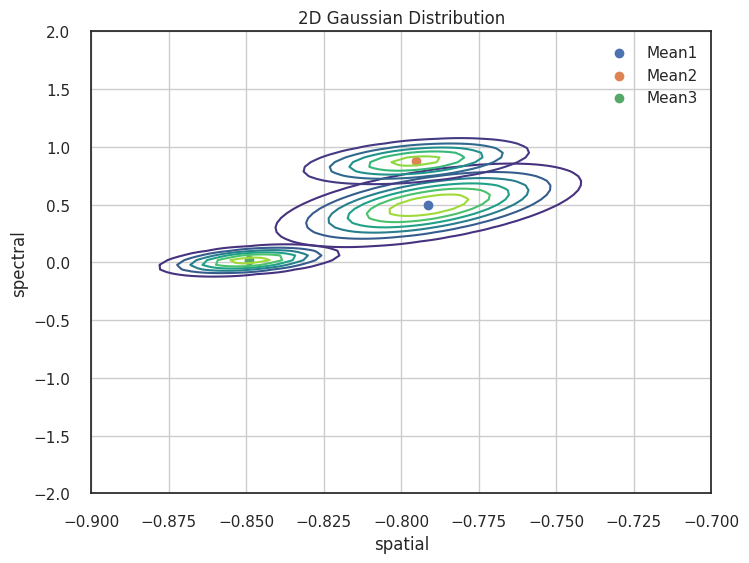

In [143]:
from scipy.stats import multivariate_normal, norm
plt.figure(figsize=(8, 6))
# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 100), np.linspace(-2, 2, 100))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = multivariate_normal(loc_mean[i], loc_cov[i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)

    # Plot the Gaussian distribution using contour plot
    
    plt.contour(x, y, pdf_values, cmap='viridis')
    plt.scatter(loc_mean[i][0], loc_mean[i][1], label='Mean'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('spatial')
plt.ylabel('spectral')
plt.title('2D Gaussian Distribution')

plt.legend()
plt.grid(True)
plt.show()

In [144]:
y_gmm_label2 = gm2.predict(X)
print(y_gmm_label2)
y_gmm_label_arranged2 = np.zeros_like(y_gmm_label2)
y_gmm_label_arranged2[y_gmm_label2 == 1] = 3
y_gmm_label_arranged2[y_gmm_label2 == 0] = 2
y_gmm_label_arranged2[y_gmm_label2 == 2] = 1
y_gmm_label_arranged2 = torch.Tensor(y_gmm_label_arranged2)
y_gmm_label_arranged2 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 0 2 2 0 2 2 2 0 2 2 2 0 2 0 0 2 2
 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 0 2 2 0 2 2 2 0 2 2 0
 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 0 0 0 2 0 2 2 2 0 0 2 2 0 0
 2 0 0 2 2 0 0 0 0 2 2 2]


tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
        2., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2., 1., 1., 1.,
        1., 2., 2., 1., 2., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 2., 1., 1.,
        1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 2., 1., 1., 1., 1., 1., 2., 2.,
        1., 1., 1., 1., 1., 2., 2., 1., 1., 1., 2., 2., 2., 1., 2., 1., 1., 1.,
        2., 2., 1., 1., 2., 2., 1., 2., 

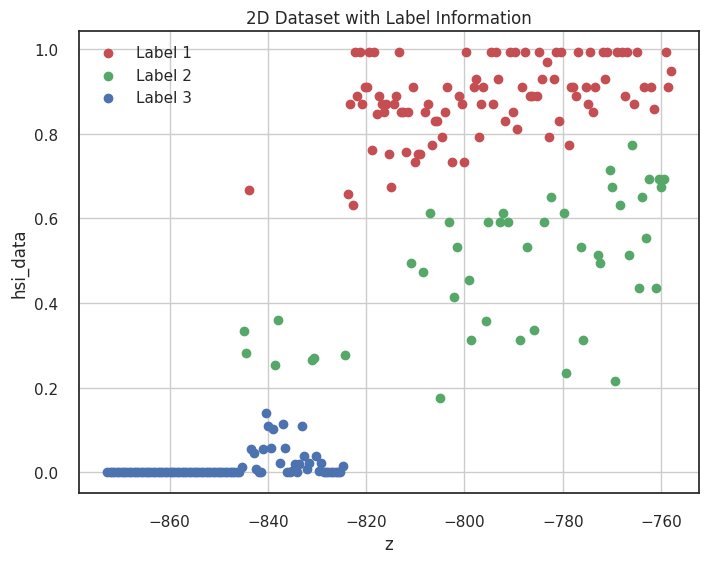

In [145]:
import matplotlib.pyplot as plt
# Define colors for each label
colors = ['r', 'g', 'b']
labels = y_gmm_label_arranged2

# Plot the dataset with different colors for each label
plt.figure(figsize=(8, 6))
for label_val, color in zip([1,2,3], colors):
    plt.scatter(position_cord[labels == label_val], hsi_data[labels == label_val], c=color, label=f'Label {label_val}')

plt.xlabel('z')
plt.ylabel('hsi_data')
plt.title('2D Dataset with Label Information')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
# A = np.zeros_like(a['BR_Anhydrite'][:, 0])
# B = np.zeros_like(a['BR_Anhydrite'][:, 0])
# C = np.zeros_like(a['BR_Anhydrite'][:, 0])

A = np.zeros_like(hsi_data)
B = np.zeros_like(hsi_data)
C = np.zeros_like(hsi_data)

# Get indices where the mask is True
# indices_A = np.where(mask & (zz[ixx] < brk1))
# indices_B = np.where(mask & (zz[ixx] > brk1) & (zz[ixx] < brk2))
# indices_C = np.where(mask & (zz[ixx] > brk2))
shift =0
# Get indices where the mask is True
indices_A = np.where(mask & (zz[ixx] < (brk1+shift)))
indices_B = np.where(mask & (zz[ixx] > (brk1+shift)) & (zz[ixx] < (brk2+shift)))
indices_C = np.where(mask & (zz[ixx] > (brk2+shift)))

y_obs_label = torch.ones(234)
y_obs_label[indices_A] =3
y_obs_label[indices_B] = 2
y_obs_label

tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [147]:
matched_label2 = y_obs_label == y_gmm_label_arranged2
(matched_label2.sum()/len(y_obs_label)) *100

tensor(67.5214)

In [148]:
#y_obs_label = y_gmm_label_arranged
y_obs_label = hsi_data.reshape((-1,1))
y_obs_label2 = X

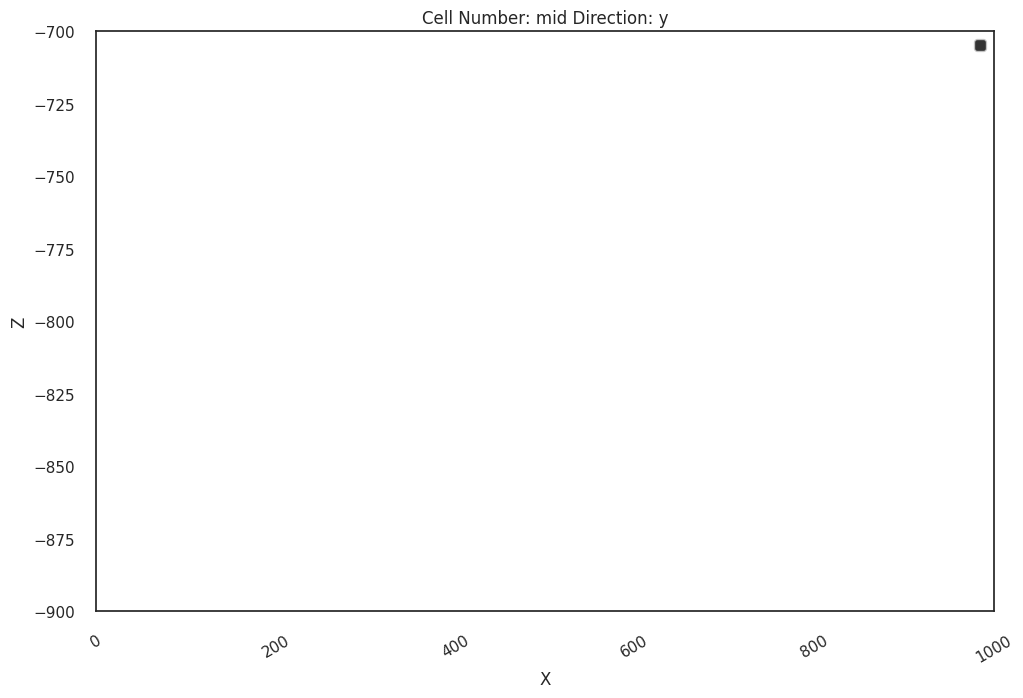

In [149]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 1000, -500, 500, -900, -700],
    resolution=[100,100,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
p2d = gpv.plot_2d(geo_model_test)

In [150]:
geo_model_test.grid.active_grids_bool

array([False, False, False, False, False])

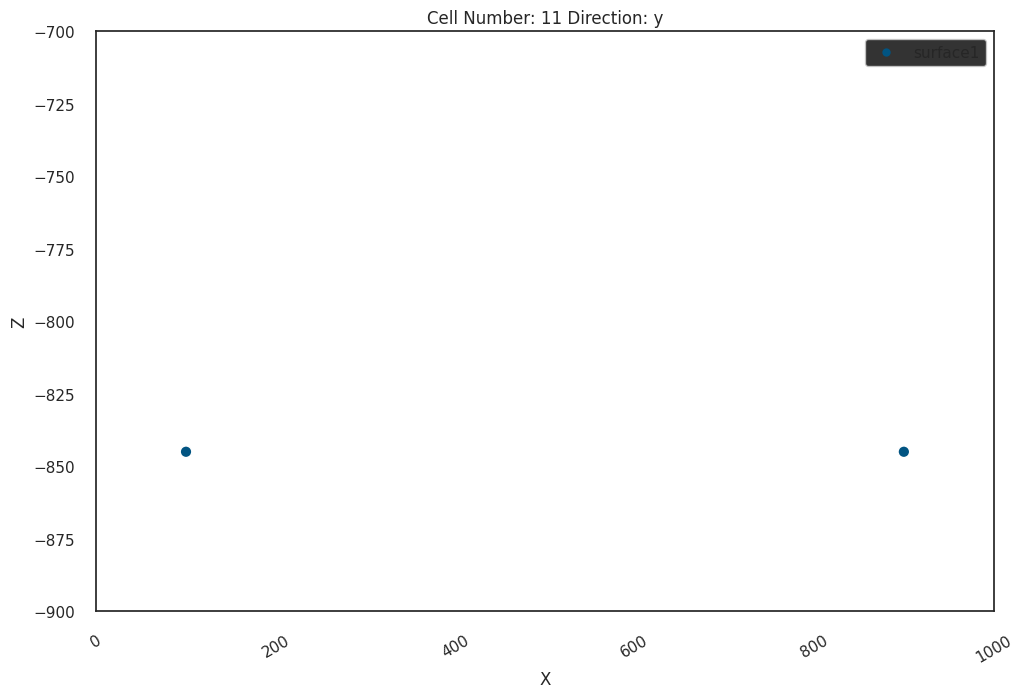

In [151]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[100.0, 900.0],
    y=[0.0, 0.0],
    z=[brk1, brk1],
    elements_names=['surface1', 'surface1']
)
gpv.plot_2d(geo_model_test, cell_number=11)

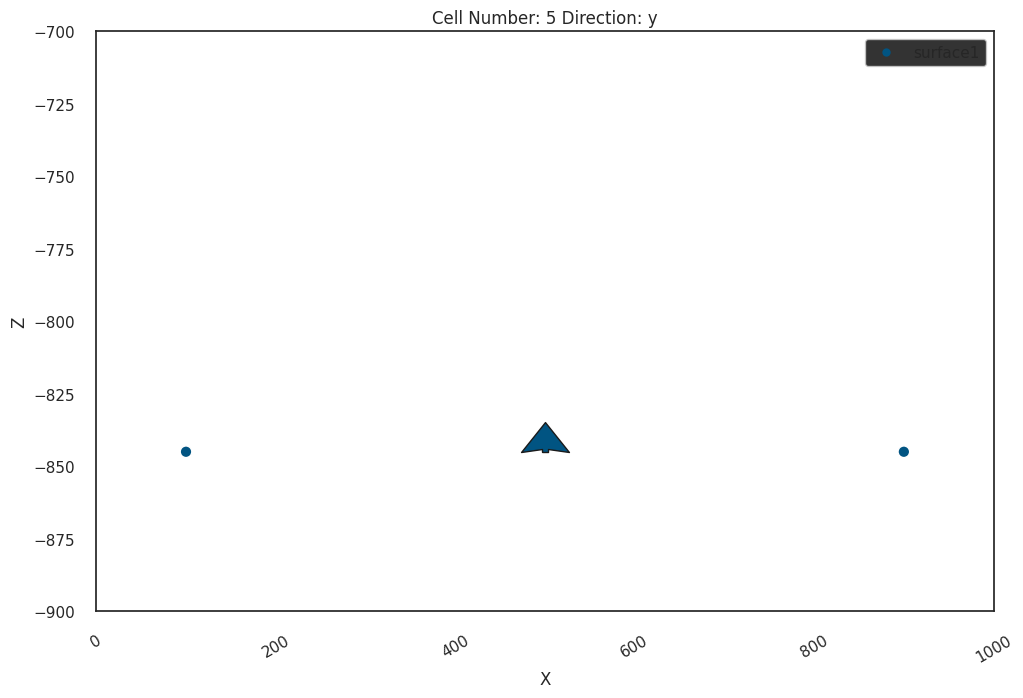

In [152]:
gp.add_orientations(
    geo_model=geo_model_test,
    x=[500],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1]]
)

gpv.plot_2d(geo_model_test, cell_number=5)

In [153]:
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

In [154]:
gp.compute_model(geo_model_test, engine_config=gp.data.GemPyEngineConfig())

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Solutions(3 Octree Levels, 1 DualContouringMeshes)

In [155]:
geo_model_test.interpolation_options.kernel_options

KernelOptions(range=5, c_o=10, uni_degree=1, i_res=4, gi_res=2, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, compute_condition_number=False, kernel_solver=Solvers.DEFAULT)

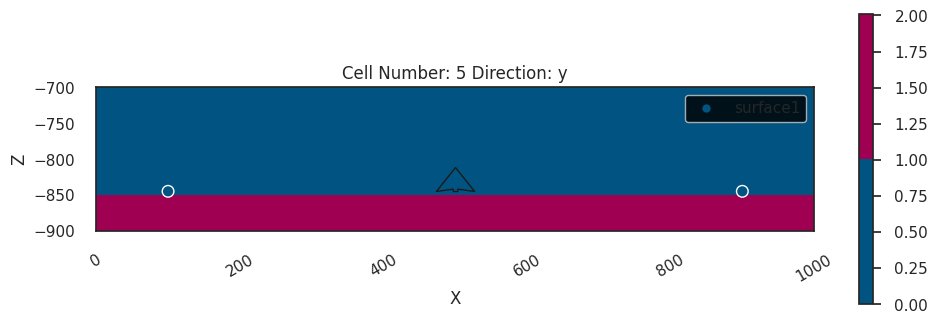

In [156]:
gpv.plot_2d(geo_model_test, cell_number=[5])

In [157]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

Setting Backend To: AvailableBackends.numpy


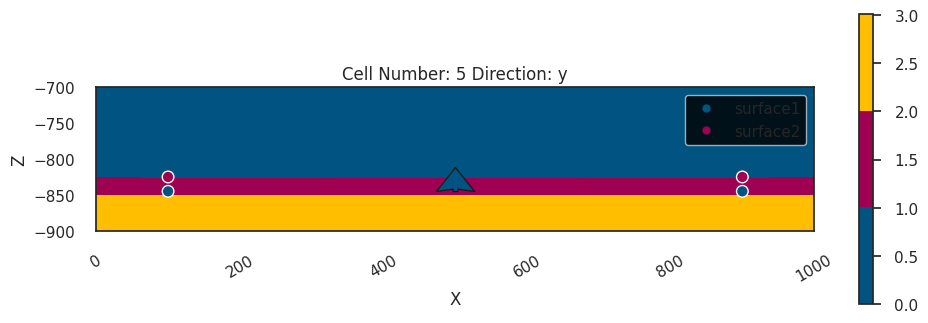

In [158]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([100.0, 900.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([brk2, brk2]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)
# Compute and visualize the updated model:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    

In [159]:
#gpv.plot_3d(geo_model_test, image=True)

In [160]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
),
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [161]:
geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

In [162]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
),
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

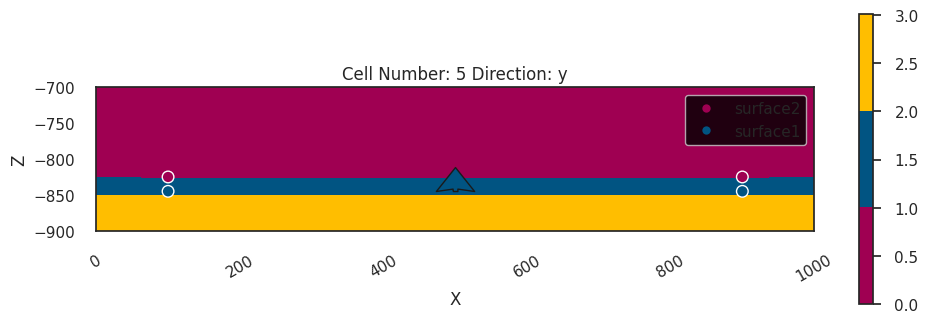

In [163]:
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

# Create a custome grid where the observed data information is available 

In [164]:
x_loc = 300
y_loc = 0
z_loc = position_cord
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

Active grids: ['custom']


In [165]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.]])

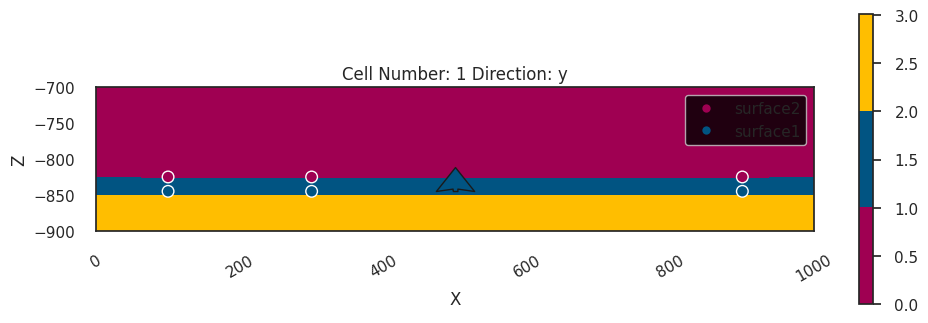

In [166]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[x_loc, x_loc],
    y=[0.0, 0.0],
    z=[brk1, brk2],
    elements_names=['surface1', 'surface2']
)
gpv.plot_2d(geo_model_test, cell_number=1)

In [167]:
geo_model_test.surface_points

X,Y,Z,id,nugget
100.00,0.00,-825.00,32258912,0.00
900.00,0.00,-825.00,32258912,0.00
300.00,0.00,-825.00,32258912,0.00
100.00,0.00,-845.00,20554098,0.00
900.00,0.00,-845.00,20554098,0.00
300.00,0.00,-845.00,20554098,0.00


Setting Backend To: AvailableBackends.numpy


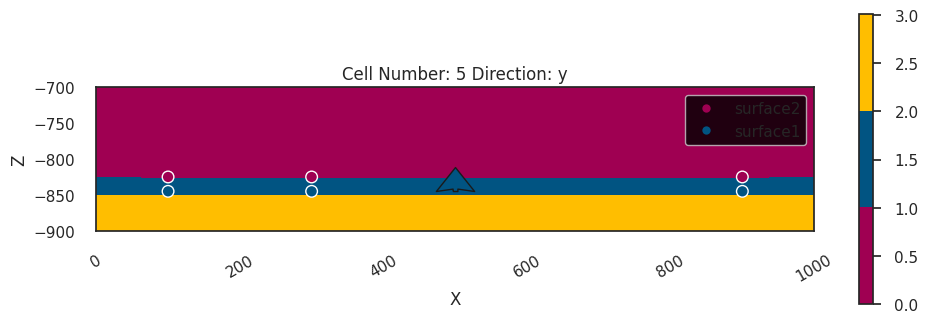

In [168]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [169]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 300.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.],
       [ 300.,    0., -845.]])

In [170]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)
# Set random seed for PyTorch backend
torch.manual_seed(42)

Setting Backend To: AvailableBackends.PYTORCH


In [171]:
geo_model_test.interpolation_options.uni_degree = 0
geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 1100.

In [172]:
#geo_model_test.solutions.octrees_output[0].last_output_center

In [173]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values.shape

(234,)

In [174]:
y_obs_label.shape, y_obs_label2.shape

((234, 1), (234, 2))

In [175]:
geo_model_test.surface_points

X,Y,Z,id,nugget
100.00,0.00,-825.00,32258912,0.00
900.00,0.00,-825.00,32258912,0.00
300.00,0.00,-825.00,32258912,0.00
100.00,0.00,-845.00,20554098,0.00
900.00,0.00,-845.00,20554098,0.00
300.00,0.00,-845.00,20554098,0.00


In [176]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
500.00,0.00,-845.00,0.00,0.00,1.00,20554098,0.01


In [177]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 300.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.],
       [ 300.,    0., -845.]])

Condition number: 45563.51606337355.
Condition number: 45563.51606337355.


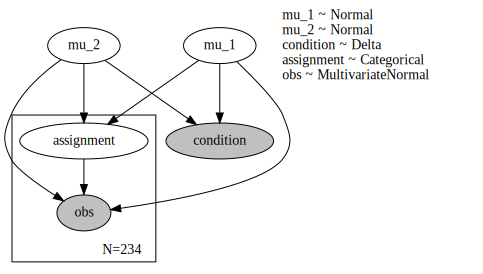

In [178]:

# Set random seed for Pyro
pyro.set_rng_seed(42)

@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[2, 2]
    prior_mean_surface_2 = sp_coords_copy_test[5, 2]
    
    

    
    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.02, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.02, dtype=torch.float64)))
    
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('condition', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([2]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_2
    )
    

    
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
        
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    # accuracy_intermediate = torch.sum(torch.round(custom_grid_values) == y_obs_label) / y_obs_label.shape[0]
    # store_accuracy.append(accuracy_intermediate)
    lambda_ = 20.0
    # loc_mean = torch.tensor(mean_init,dtype=torch.float64)
    # loc_cov =  torch.tensor(cov_init, dtype=torch.float64)
    z_nk = F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    #class_label = torch.mean(F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1),dim=0)
    
    N_k = torch.sum(z_nk,axis=0)
    N = len(custom_grid_values)
    pi_k = N_k /N
    mean = []
    cov = []
    for i in range(z_nk.shape[1]):
        mean_k = torch.sum( z_nk[:,i][:,None] * y_obs_label, axis=0)/ N_k[i]
        #cov_k = torch.sum( (normalised_hsi - mean_k.reshape((-1,1))) (normalised_hsi - mean_k).T )
        cov_k = torch.zeros((mean_k.shape[0],mean_k.shape[0]),dtype=torch.float64)
        for j in range(z_nk.shape[0]):
                cov_k +=  z_nk[j,i]* torch.matmul((y_obs_label[j,:] - mean_k).reshape((-1,1)) ,(y_obs_label[j,:] - mean_k).reshape((1,-1)))
        mean.append(mean_k)
        cov_k=cov_k/N_k[i] #+ 1e-3 * torch.diag(torch.ones(cov_k.shape[0],dtype=torch.float64))
        cov.append(cov_k)
    mean_tensor = torch.stack(mean, dim=0)
    cov_tensor = torch.stack(cov,dim=0)
    
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(pi_k))
        
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=mean_tensor[assignment],covariance_matrix=cov_tensor[assignment]), obs=y_obs_label)
        
    return obs
    
dependencies = get_dependencies(model_test, model_args=(torch.tensor(X),))
pyro.render_model(model_test, model_args=(torch.tensor(X),),render_distributions=True)


In [179]:
y_obs_label =torch.tensor(X)

In [180]:

model_test(y_obs_label)

Condition number: 45563.51606337354.


tensor([[-0.8727,  0.0000],
        [-0.8722,  0.0000],
        [-0.8717,  0.0000],
        [-0.8713,  0.0000],
        [-0.8708,  0.0000],
        [-0.8703,  0.0000],
        [-0.8698,  0.0000],
        [-0.8693,  0.0000],
        [-0.8688,  0.0000],
        [-0.8683,  0.0000],
        [-0.8678,  0.0000],
        [-0.8674,  0.0000],
        [-0.8669,  0.0000],
        [-0.8664,  0.0000],
        [-0.8659,  0.0000],
        [-0.8654,  0.0000],
        [-0.8649,  0.0000],
        [-0.8644,  0.0000],
        [-0.8639,  0.0000],
        [-0.8635,  0.0000],
        [-0.8630,  0.0000],
        [-0.8625,  0.0000],
        [-0.8620,  0.0000],
        [-0.8615,  0.0000],
        [-0.8610,  0.0000],
        [-0.8605,  0.0000],
        [-0.8600,  0.0000],
        [-0.8595,  0.0000],
        [-0.8591,  0.0000],
        [-0.8586,  0.0000],
        [-0.8581,  0.0000],
        [-0.8576,  0.0000],
        [-0.8571,  0.0000],
        [-0.8566,  0.0000],
        [-0.8561,  0.0000],
        [-0.8556,  0

Condition number: 25866.2956086494.
Condition number: 21554.66756361934.
Condition number: 52751.31147103856.
Condition number: 21776.21402991603.
Condition number: 52933.9791256113.
Condition number: 51945.788233243075.
Condition number: 36794.30857520832.
Condition number: 44970.204167595424.
Condition number: 54509.50143215695.
Condition number: 44660.786796377935.
Condition number: 28919.327093894306.
Condition number: 40058.96595913754.
Condition number: 25828.218843563027.
Condition number: 36464.544724691696.
Condition number: 21351.398697267196.
Condition number: 36290.196225199106.
Condition number: 50519.338928757184.
Condition number: 24685.35397522019.
Condition number: 28298.62542462437.
Condition number: 20949.103445534864.
Condition number: 50456.68736188622.
Condition number: 54018.05839847855.
Condition number: 54516.63983265105.
Condition number: 51432.10037646749.
Condition number: 21165.325039573185.
Condition number: 53633.68085986548.
Condition number: 32658.48170

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


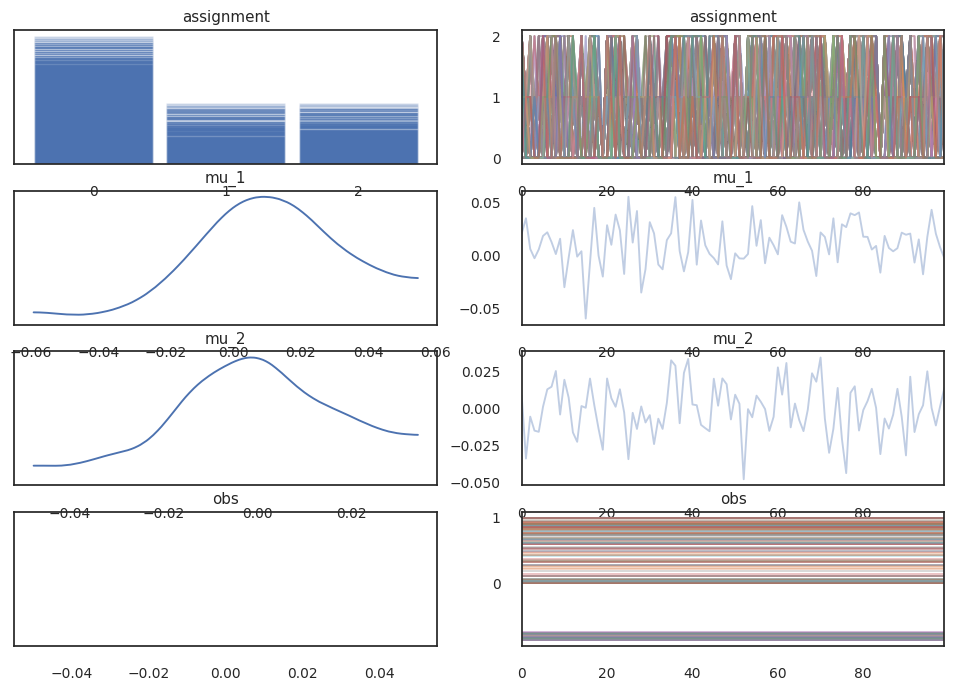

In [181]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = 'condition'

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key != avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [182]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/250 [00:00, ?it/s]

Condition number: 50547.09829247094.
Condition number: 52007.342765863155.
Condition number: 52007.342765863155.
Condition number: 52007.342765863155.
Condition number: 52007.342765863155.
Condition number: 52007.342765863155.
Condition number: 46695.09206096479.
Condition number: 52007.342765863155.
Condition number: 20664.658642833612.
Condition number: 52007.342765863155.
Condition number: 20426.07141132289.
Condition number: 52007.342765863155.
Condition number: 28758.00646910583.
Condition number: 52007.342765863155.
Condition number: 44814.56896282205.


Warmup:   0%|          | 1/250 [00:01,  1.45s/it, step size=6.37e-03, acc. prob=1.000]

Condition number: 46559.78108139594.
Condition number: 57309.91915792511.
Condition number: 42521.37647428536.


Warmup:   1%|          | 3/250 [00:01,  2.23it/s, step size=5.73e-05, acc. prob=0.333]

Condition number: 46911.11221861644.
Condition number: 46556.01634104371.
Condition number: 46879.623259759945.


Warmup:   2%|▏         | 4/250 [00:01,  2.53it/s, step size=4.77e-05, acc. prob=0.488]

Condition number: 46754.620548213534.
Condition number: 46819.46213840439.
Condition number: 47063.030815170474.


Warmup:   2%|▏         | 5/250 [00:02,  2.76it/s, step size=5.24e-05, acc. prob=0.590]

Condition number: 47095.5967282669.
Condition number: 47322.03094678074.
Condition number: 47718.781841793.


Warmup:   2%|▏         | 6/250 [00:02,  2.94it/s, step size=6.28e-05, acc. prob=0.658]

Condition number: 47902.982745730114.
Condition number: 48288.89037928289.
Condition number: 48833.68802120734.
Condition number: 49452.30973998915.
Condition number: 49928.15424715035.
Condition number: 49883.988539134.


Warmup:   3%|▎         | 7/250 [00:03,  2.23it/s, step size=5.11e-05, acc. prob=0.687]

Condition number: 49707.515625064334.
Condition number: 48870.538700161684.
Condition number: 48969.532968979554.
Condition number: 49126.20375458185.
Condition number: 48859.315559846604.
Condition number: 48937.864236691305.
Condition number: 49042.957291657425.
Condition number: 49140.686835897875.


Warmup:   3%|▎         | 8/250 [00:04,  1.68it/s, step size=6.18e-05, acc. prob=0.723]

Condition number: 49138.93523789701.
Condition number: 49354.94896778546.
Condition number: 49569.01219085274.
Condition number: 49781.73290483001.
Condition number: 50003.162917948.
Condition number: 50236.78542137081.
Condition number: 50504.135221895325.
Condition number: 50805.69073028323.
Condition number: 51123.56784021193.
Condition number: 51443.57621330111.
Condition number: 51748.485688643384.
Condition number: 52020.91594877202.
Condition number: 52254.733898303864.
Condition number: 52450.67681759973.
Condition number: 52626.13388492067.
Condition number: 48774.36697640746.
Condition number: 48666.17201001593.
Condition number: 48621.361042130964.
Condition number: 48636.64936239566.
Condition number: 48697.96454687902.
Condition number: 48786.06507768379.
Condition number: 48881.99660786003.


Warmup:   4%|▎         | 9/250 [00:06,  1.13s/it, step size=7.64e-05, acc. prob=0.751]

Condition number: 48972.9053823805.
Condition number: 51971.08074625443.


Warmup:   4%|▍         | 10/250 [00:06,  1.14it/s, step size=1.04e-04, acc. prob=0.776]

Condition number: 52028.56605406818.
Condition number: 52017.54151680137.
Condition number: 51841.50513313108.
Condition number: 51675.225021780825.
Condition number: 51570.66640131284.
Condition number: 52176.05333392899.
Condition number: 52260.05412265497.
Condition number: 52308.42929979066.
Condition number: 52360.03766683313.
Condition number: 52417.005921827775.
Condition number: 52452.68258428081.


Warmup:   4%|▍         | 11/250 [00:08,  1.01it/s, step size=1.36e-04, acc. prob=0.794]

Condition number: 52437.50021746479.
Condition number: 52369.40963596524.


Warmup:   5%|▍         | 12/250 [00:08,  1.38it/s, step size=1.02e-05, acc. prob=0.734]

Condition number: 52337.51207290954.
Condition number: 52259.265543381676.
Condition number: 52258.11556528406.
Condition number: 52256.575051281005.
Condition number: 52260.51021402211.
Condition number: 52260.661978932556.
Condition number: 52260.53636760783.
Condition number: 52260.15869459199.
Condition number: 52259.55226044443.
Condition number: 52258.7380396472.
Condition number: 52257.734403704635.
Condition number: 52256.55690744935.
Condition number: 52255.21810445821.
Condition number: 52253.72742141562.
Condition number: 52252.09104446523.
Condition number: 52250.31186495472.


Warmup:   5%|▌         | 13/250 [00:09,  1.01s/it, step size=1.43e-05, acc. prob=0.755]

Condition number: 52240.146793310385.
Condition number: 52220.55596481357.
Condition number: 52201.0606345463.
Condition number: 52181.91850286379.
Condition number: 52163.35934968224.
Condition number: 52145.58247677473.
Condition number: 52128.7557152944.
Condition number: 52113.015298396385.
Condition number: 52098.466056811805.
Condition number: 52085.18145586785.
Condition number: 52073.20330710313.
Condition number: 52062.540939798244.
Condition number: 52053.16992628773.
Condition number: 52045.03058791288.


Warmup:   6%|▌         | 14/250 [00:11,  1.16s/it, step size=2.00e-05, acc. prob=0.772]

Condition number: 52038.026829600254.
Condition number: 52019.1975750609.
Condition number: 51995.97102395986.
Condition number: 51975.710626704466.
Condition number: 52072.96355444308.
Condition number: 52102.34451983631.
Condition number: 52132.394916944875.
Condition number: 52162.2596986725.
Condition number: 51958.63176286769.
Condition number: 51944.80490741788.
Condition number: 51934.15058514999.
Condition number: 51926.433323063306.
Condition number: 51921.26488138087.
Condition number: 51918.13819333963.
Condition number: 51916.5157133882.
Condition number: 51915.94484966305.
Condition number: 52191.08266626372.
Condition number: 52218.06381564808.
Condition number: 52242.458932539725.
Condition number: 52263.553142682904.
Condition number: 52280.667911276585.
Condition number: 52293.21363656964.
Condition number: 52300.76764236821.


Warmup:   6%|▌         | 15/250 [00:13,  1.57s/it, step size=2.80e-05, acc. prob=0.787]

Condition number: 52303.14499624008.
Condition number: 51909.48582773539.
Condition number: 51923.77609286749.
Condition number: 51932.3951184886.
Condition number: 51904.84871978882.
Condition number: 51902.35811918724.
Condition number: 51902.170777500476.


Warmup:   6%|▋         | 16/250 [00:14,  1.35s/it, step size=3.88e-05, acc. prob=0.800]

Condition number: 51904.241751948764.
Condition number: 51906.2788017709.
Condition number: 51866.94303395339.
Condition number: 51795.726155576995.
Condition number: 51958.39924918017.
Condition number: 51990.68285983499.
Condition number: 52039.19867732458.
Condition number: 52106.661855012535.
Condition number: 51683.69785215791.
Condition number: 51532.154848227925.
Condition number: 51351.15281928943.
Condition number: 51153.67807947376.
Condition number: 50953.37601060738.
Condition number: 50762.94767570839.
Condition number: 50592.25937835439.
Condition number: 50448.26547443506.
Condition number: 50334.52041535376.
Condition number: 50250.71748306837.
Condition number: 50193.46884881799.
Condition number: 50162.155279971754.
Condition number: 50153.19380727407.
Condition number: 50151.82936536835.
Condition number: 50143.58601274922.
Condition number: 50115.608089945985.
Condition number: 50055.55729962945.
Condition number: 49962.989510687235.
Condition number: 49850.73344127

Warmup:   7%|▋         | 17/250 [00:17,  1.94s/it, step size=3.05e-05, acc. prob=0.801]

Condition number: 51637.419813519606.
Condition number: 51707.05934955325.
Condition number: 51707.36702346492.
Condition number: 51571.72322669118.
Condition number: 51491.776310409885.
Condition number: 51404.35096209538.
Condition number: 51317.623997409115.


Warmup:   7%|▋         | 18/250 [00:18,  1.62s/it, step size=4.30e-05, acc. prob=0.812]

Condition number: 51400.74724244861.
Condition number: 51411.35732018863.
Condition number: 51421.151363100944.
Condition number: 51432.70156269862.
Condition number: 51444.718071729374.
Condition number: 51455.86207296889.


Warmup:   8%|▊         | 19/250 [00:19,  1.34s/it, step size=6.03e-05, acc. prob=0.822]

Condition number: 51464.980304802724.
Condition number: 51459.41078534495.
Condition number: 51436.44646222136.
Condition number: 51390.249553031725.
Condition number: 51322.31826854655.
Condition number: 51239.65572225995.
Condition number: 51151.25179559308.
Condition number: 51064.48288719517.
Condition number: 50983.45300195813.
Condition number: 50910.38270817509.
Condition number: 50846.68732051356.
Condition number: 50791.81584525524.
Condition number: 50745.557437566495.
Condition number: 50711.0875915732.


Warmup:   8%|▊         | 20/250 [00:21,  1.39s/it, step size=8.29e-05, acc. prob=0.830]

Condition number: 50694.42968522128.
Condition number: 50701.25785554618.
Condition number: 51261.75229752387.
Condition number: 51252.65487612045.


Warmup:   8%|▊         | 21/250 [00:21,  1.07s/it, step size=1.10e-04, acc. prob=0.837]

Condition number: 51207.15887895369.
Condition number: 51401.74154852805.
Condition number: 51035.69116442066.
Condition number: 50751.7169546799.
Condition number: 50533.507027275286.
Condition number: 50450.392277629384.


Warmup:   9%|▉         | 22/250 [00:22,  1.04it/s, step size=8.03e-05, acc. prob=0.835]

Condition number: 50505.59172926141.
Condition number: 50578.18566796883.
Condition number: 51360.86648404752.
Condition number: 51472.63055825929.
Condition number: 51570.14711806765.
Condition number: 51340.03664108882.
Condition number: 51315.69389808034.
Condition number: 51263.188441724975.
Condition number: 51175.61254446739.
Condition number: 51066.2627161309.
Condition number: 50958.43883898149.
Condition number: 50871.0397305857.
Condition number: 50813.07530372744.
Condition number: 50784.05541720085.


Warmup:   9%|▉         | 23/250 [00:23,  1.07s/it, step size=1.11e-04, acc. prob=0.842]

Condition number: 50774.07084736951.
Condition number: 50771.15470342944.
Condition number: 51664.283699665175.
Condition number: 51960.07301880261.
Condition number: 52243.264999916864.
Condition number: 52563.50353147431.
Condition number: 52897.278820659565.
Condition number: 53162.65373304453.
Condition number: 50325.02044792697.
Condition number: 50020.578140689555.
Condition number: 49838.25593222687.
Condition number: 49694.81285685868.
Condition number: 49541.600985927194.
Condition number: 49498.15491670606.


Warmup:  10%|▉         | 24/250 [00:24,  1.20s/it, step size=1.25e-04, acc. prob=0.846]

Condition number: 49616.827604699356.
Condition number: 49866.54093317896.
Condition number: 52544.05322066558.
Condition number: 51997.254874081475.
Condition number: 51691.97781904747.
Condition number: 52885.67083177577.
Condition number: 53148.32819214836.
Condition number: 53230.14560677232.
Condition number: 53250.54275113055.
Condition number: 53306.73853835277.
Condition number: 53385.52207426087.
Condition number: 53395.67633783474.


Warmup:  10%|█         | 26/250 [00:26,  1.17it/s, step size=2.13e-04, acc. prob=0.856]

Condition number: 53267.61864593137.
Condition number: 53302.53986937402.
Condition number: 53371.54884184659.
Condition number: 53241.13602211895.
Condition number: 52504.94511474871.
Condition number: 53468.32184768591.
Condition number: 52459.39405426864.
Condition number: 52363.30833947853.


Warmup:  11%|█         | 27/250 [00:26,  1.22it/s, step size=2.38e-05, acc. prob=0.829]

Condition number: 52911.6036896164.
Condition number: 53350.61587068742.
Condition number: 53392.68393877327.
Condition number: 53413.86797974014.
Condition number: 53329.975713917236.
Condition number: 53309.60906087547.
Condition number: 53289.33594441955.
Condition number: 53268.7783334916.
Condition number: 53247.33733488147.
Condition number: 53224.18558454521.
Condition number: 53198.29990978829.
Condition number: 53168.5883116325.
Condition number: 53134.12785697437.
Condition number: 53094.368852637555.
Condition number: 53049.108988061256.
Condition number: 52998.33194786081.
Condition number: 52942.13417649303.
Condition number: 52880.75586437157.
Condition number: 52814.62979115034.
Condition number: 52744.39873882241.
Condition number: 52670.89091554825.
Condition number: 52595.06192388554.
Condition number: 52517.923502821264.
Condition number: 52440.47866234785.
Condition number: 52363.67050919269.
Condition number: 52288.34172342807.
Condition number: 52215.19821391993.


Warmup:  11%|█         | 28/250 [00:31,  1.89s/it, step size=3.28e-05, acc. prob=0.835]

Condition number: 52710.490169515186.
Condition number: 52673.6978241839.
Condition number: 52635.40134578059.
Condition number: 52597.053880462234.
Condition number: 52560.01992794232.
Condition number: 52525.47223068993.
Condition number: 52494.33747565625.
Condition number: 52467.26279062641.
Condition number: 52444.57559797597.
Condition number: 52426.22303759814.
Condition number: 52411.69522154775.
Condition number: 52399.94949483262.
Condition number: 52389.360749884014.
Condition number: 52377.743553746404.
Condition number: 52362.53566810528.
Condition number: 52341.23183527099.
Condition number: 52311.94770967714.
Condition number: 52273.712481279115.
Condition number: 52226.375694630246.
Condition number: 52170.48362915109.
Condition number: 52107.25255263655.
Condition number: 52038.485267635784.
Condition number: 51966.352440294555.
Condition number: 51893.113510162686.
Condition number: 51820.90246702989.
Condition number: 51751.62255593983.
Condition number: 51686.913097

Warmup:  12%|█▏        | 29/250 [00:37,  3.20s/it, step size=4.50e-05, acc. prob=0.840]

Condition number: 50650.75151601185.
Condition number: 52266.309710241236.
Condition number: 52208.59040842565.
Condition number: 52144.21743081454.
Condition number: 52078.05590414539.
Condition number: 52013.29414565929.
Condition number: 51951.15129200463.
Condition number: 51891.842902374956.
Condition number: 52340.881846323704.
Condition number: 52350.39094454062.


Warmup:  12%|█▏        | 30/250 [00:38,  2.57s/it, step size=6.06e-05, acc. prob=0.846]

Condition number: 52340.32576394559.
Condition number: 52313.18050281759.
Condition number: 51893.59564737332.
Condition number: 52014.332654959806.
Condition number: 52087.630919184354.
Condition number: 52170.50820686987.
Condition number: 52253.2569589781.
Condition number: 52319.75736239342.
Condition number: 52354.79890108657.
Condition number: 52350.47398489339.
Condition number: 52309.62101061059.
Condition number: 52244.70492732133.
Condition number: 52173.3499231973.
Condition number: 52109.86660869237.
Condition number: 52060.195277741.
Condition number: 52020.73152882325.


Warmup:  12%|█▏        | 31/250 [00:40,  2.26s/it, step size=7.78e-05, acc. prob=0.850]

Condition number: 51982.44656003377.
Condition number: 51872.69049141839.
Condition number: 52167.37835708737.
Condition number: 52309.79998441854.
Condition number: 52434.55669262951.
Condition number: 52521.33492645941.
Condition number: 52560.04484807541.
Condition number: 52563.85331408034.
Condition number: 52561.81245675771.
Condition number: 52575.60322650733.
Condition number: 52610.52760261357.


Warmup:  13%|█▎        | 32/250 [00:41,  1.91s/it, step size=1.03e-04, acc. prob=0.854]

Condition number: 52661.90079822278.
Condition number: 52247.88779031279.
Condition number: 52848.806460714404.
Condition number: 53085.70624890865.
Condition number: 53259.06121975377.
Condition number: 53376.49466839907.
Condition number: 53452.89555826362.
Condition number: 53506.617495051265.
Condition number: 53538.859849278.
Condition number: 53539.59524499881.


Warmup:  13%|█▎        | 33/250 [00:42,  1.73s/it, step size=1.33e-04, acc. prob=0.858]

Condition number: 53491.269600709216.
Condition number: 53394.0761413549.
Condition number: 53414.45752836261.
Condition number: 53562.02440648603.


Warmup:  14%|█▎        | 34/250 [00:42,  1.30s/it, step size=2.75e-05, acc. prob=0.842]

Condition number: 53690.01028591063.
Condition number: 53525.32929217685.
Condition number: 53490.6138518628.
Condition number: 53456.59573030487.
Condition number: 53422.051964591185.
Condition number: 53386.67390456867.
Condition number: 53349.44533846528.
Condition number: 53307.69018711581.
Condition number: 53601.330853469655.
Condition number: 53643.335101768374.
Condition number: 53687.75620878846.
Condition number: 53734.0650794476.
Condition number: 53781.56067985395.
Condition number: 53829.40982482767.
Condition number: 53876.65128034985.
Condition number: 53922.18812012459.
Condition number: 53964.80327648282.
Condition number: 54003.21660042533.
Condition number: 54036.20456605204.
Condition number: 54062.77454171738.
Condition number: 54082.314048304834.
Condition number: 54094.67642770244.


Warmup:  14%|█▍        | 35/250 [00:45,  1.61s/it, step size=3.71e-05, acc. prob=0.846]

Condition number: 54100.20316832114.
Condition number: 54099.66337470185.
Condition number: 53916.66768632134.
Condition number: 53907.94089035414.
Condition number: 53895.37780126363.
Condition number: 53925.070518754146.
Condition number: 53925.79548982358.
Condition number: 53924.73373879157.


Warmup:  14%|█▍        | 36/250 [00:45,  1.34s/it, step size=5.00e-05, acc. prob=0.850]

Condition number: 53922.12994133442.
Condition number: 53926.82877193403.
Condition number: 53914.81646571875.
Condition number: 53905.85898019464.
Condition number: 53927.37503356674.
Condition number: 53921.8154409732.


Warmup:  15%|█▍        | 37/250 [00:46,  1.15s/it, step size=6.67e-05, acc. prob=0.854]

Condition number: 53908.03893025535.
Condition number: 53884.08938813235.
Condition number: 53940.858890457705.
Condition number: 53856.25475318075.
Condition number: 53794.35704114904.
Condition number: 53729.349957293634.
Condition number: 53663.873800697686.
Condition number: 53592.6843709416.
Condition number: 53504.29243119075.
Condition number: 53391.21445887893.
Condition number: 53233.07430645952.
Condition number: 53016.5224114729.
Condition number: 52751.74448260327.
Condition number: 52460.51143216719.
Condition number: 52165.05832002897.
Condition number: 51878.081389936575.
Condition number: 51597.1793042684.
Condition number: 51332.58526727295.
Condition number: 51054.69993635964.
Condition number: 50750.38119399994.
Condition number: 50405.69396485462.
Condition number: 50028.33365885476.
Condition number: 49649.22243746078.
Condition number: 49302.36011431859.
Condition number: 49016.419581605085.
Condition number: 48804.807175279006.
Condition number: 48658.13988408205

Warmup:  15%|█▌        | 38/250 [00:49,  1.80s/it, step size=7.98e-05, acc. prob=0.857]

Condition number: 48496.28330511952.
Condition number: 52092.42227092886.


Warmup:  16%|█▌        | 39/250 [00:50,  1.35s/it, step size=9.95e-05, acc. prob=0.860]

Condition number: 52066.578634156955.
Condition number: 52068.86549940248.


Warmup:  16%|█▌        | 40/250 [00:50,  1.03it/s, step size=1.29e-04, acc. prob=0.863]

Condition number: 52085.93653724088.
Condition number: 52118.55497174616.
Condition number: 51997.514682786845.
Condition number: 51772.20970343692.
Condition number: 51644.74543093301.
Condition number: 51640.2007422644.
Condition number: 51527.967072089676.
Condition number: 51162.27436377235.
Condition number: 52149.64404691164.
Condition number: 52371.935254981814.


Warmup:  16%|█▋        | 41/250 [00:51,  1.02s/it, step size=1.49e-04, acc. prob=0.865]

Condition number: 52608.14507563797.
Condition number: 52570.19209029004.
Condition number: 52079.10996193928.
Condition number: 52058.96261180906.


Warmup:  17%|█▋        | 42/250 [00:51,  1.24it/s, step size=9.23e-05, acc. prob=0.861]

Condition number: 52190.67249803413.
Condition number: 52051.448270184184.
Condition number: 52124.646838641354.
Condition number: 52259.01549356101.
Condition number: 52038.17422008704.
Condition number: 51944.07147181313.
Condition number: 51760.16735853016.
Condition number: 51591.421695103636.


Warmup:  17%|█▋        | 43/250 [00:52,  1.29it/s, step size=1.11e-04, acc. prob=0.864]

Condition number: 52128.54371475262.
Condition number: 52128.54371475262.
Condition number: 52128.54371475262.
Condition number: 52128.22040889626.
Condition number: 52128.54371475262.
Condition number: 52119.55117208842.
Condition number: 52128.54371475262.
Condition number: 52132.46701113274.
Condition number: 52128.54371475262.
Condition number: 52139.39002180474.
Condition number: 52128.54371475262.
Condition number: 52110.27393539008.
Condition number: 52128.54371475262.
Condition number: 52038.384475175604.
Condition number: 52128.54371475262.
Condition number: 52221.80384558486.
Condition number: 52128.54371475262.
Condition number: 52185.63138939756.
Condition number: 52128.54371475262.


Warmup:  18%|█▊        | 44/250 [00:54,  1.17s/it, step size=3.74e-02, acc. prob=0.867]

Condition number: 52506.53186593464.
Condition number: 52422.53035870458.


Warmup:  18%|█▊        | 45/250 [00:54,  1.13it/s, step size=7.27e-02, acc. prob=0.847]

Condition number: 32287.626699277746.
Condition number: 53579.38613260255.


Warmup:  18%|█▊        | 46/250 [00:54,  1.54it/s, step size=5.37e-03, acc. prob=0.829]

Condition number: 52033.96445702426.
Condition number: 52235.80994946822.
Condition number: 52328.30275351791.
Condition number: 51969.68552375184.
Condition number: 51942.75960822625.
Condition number: 51950.7679915996.


Warmup:  19%|█▉        | 47/250 [00:55,  1.50it/s, step size=3.61e-03, acc. prob=0.832]

Condition number: 51979.178576389415.
Condition number: 52366.0217929852.
Condition number: 52273.42393506587.
Condition number: 52203.60198378286.
Condition number: 52386.608055110235.
Condition number: 52392.18330938091.


Warmup:  19%|█▉        | 48/250 [00:56,  1.47it/s, step size=3.43e-03, acc. prob=0.835]

Condition number: 52387.35049047864.
Condition number: 52378.700809312155.
Condition number: 52308.53311141587.
Condition number: 52449.96815909695.
Condition number: 52522.293559346326.
Condition number: 52595.08187071767.
Condition number: 52667.3783375134.
Condition number: 52738.02082312669.
Condition number: 52805.75150215845.
Condition number: 52238.74090975708.
Condition number: 52167.763496808504.
Condition number: 52093.77380221622.
Condition number: 52016.01998132627.
Condition number: 51934.7761792107.
Condition number: 51849.89271542158.
Condition number: 51760.76356648518.
Condition number: 51667.06449276376.
Condition number: 52869.29370977774.
Condition number: 52927.411988278145.
Condition number: 52978.98766669405.
Condition number: 53023.120710445946.
Condition number: 53059.205204458165.
Condition number: 53086.914095313274.
Condition number: 53106.10899164535.
Condition number: 53116.7434481338.
Condition number: 53118.80083717639.
Condition number: 53112.2678814798

Warmup:  20%|█▉        | 49/250 [00:59,  1.47s/it, step size=5.23e-03, acc. prob=0.839]

Condition number: 52952.31148855177.
Condition number: 52896.96826688214.
Condition number: 51800.739007040946.
Condition number: 51712.8983749136.
Condition number: 51647.00577195134.
Condition number: 51844.51900317992.
Condition number: 51897.250089715075.
Condition number: 51959.53069280471.
Condition number: 52030.763202357884.
Condition number: 52105.32344304121.
Condition number: 52173.172940637145.
Condition number: 52223.26149512759.


Warmup:  20%|██        | 50/250 [01:00,  1.36s/it, step size=5.23e-03, acc. prob=0.842]

Condition number: 52246.55573410207.
Condition number: 51978.25627542113.
Condition number: 51926.47937196038.
Condition number: 51871.68082894231.
Condition number: 52086.99639535027.
Condition number: 52149.255482052286.
Condition number: 52214.312146254706.
Condition number: 52273.29038422422.
Condition number: 52314.70369361594.
Condition number: 52329.22862926473.


Warmup:  20%|██        | 51/250 [01:01,  1.29s/it, step size=5.23e-03, acc. prob=0.998]

Condition number: 52312.92003236627.
Condition number: 52268.665198099385.
Condition number: 52102.43277309724.
Condition number: 51968.71542646576.
Condition number: 51792.796633884835.
Condition number: 52318.53385684991.
Condition number: 52437.942428250775.
Condition number: 52573.8098653164.
Condition number: 52719.72333627878.
Condition number: 51565.25787180232.
Condition number: 51299.053880297106.
Condition number: 51017.57821663276.
Condition number: 50741.523699246114.
Condition number: 50485.23464594632.
Condition number: 50262.1551753637.
Condition number: 50079.449642477055.
Condition number: 49924.61062616665.
Condition number: 52869.51806611446.
Condition number: 53010.92075742535.
Condition number: 53128.0500024796.
Condition number: 53204.83110444043.
Condition number: 53233.41961787447.
Condition number: 53220.252843750764.
Condition number: 53182.46604786739.
Condition number: 53143.779753311464.
Condition number: 53117.368741791855.


Sample:  21%|██        | 52/250 [01:04,  1.72s/it, step size=5.23e-03, acc. prob=0.983]

Condition number: 53107.55837843259.
Condition number: 50914.14589271019.
Condition number: 51097.8600955082.
Condition number: 51273.78734923017.
Condition number: 50593.46561534773.
Condition number: 50477.904083726964.
Condition number: 50400.201045007445.
Condition number: 50357.2385884249.
Condition number: 51420.98392981048.
Condition number: 51526.918371333464.
Condition number: 51593.819435162135.
Condition number: 51645.10338320105.
Condition number: 51707.42025933624.
Condition number: 51788.07622174899.
Condition number: 51888.20655784354.
Condition number: 52008.846355766924.
Condition number: 50329.72315145377.
Condition number: 50290.354593685035.
Condition number: 50225.16504103095.
Condition number: 50134.77204338944.
Condition number: 50031.98268859132.
Condition number: 49935.119672245426.
Condition number: 49863.06996744428.
Condition number: 49829.355796175136.


Sample:  21%|██        | 53/250 [01:07,  1.96s/it, step size=5.23e-03, acc. prob=0.986]

Condition number: 51823.53723810942.
Condition number: 51782.41293169827.


Sample:  22%|██▏       | 54/250 [01:07,  1.47s/it, step size=5.23e-03, acc. prob=0.988]

Condition number: 51759.23034550238.
Condition number: 51707.18638764484.
Condition number: 51874.66453774313.
Condition number: 51975.23711478794.
Condition number: 51652.90124436597.
Condition number: 51620.76251328369.
Condition number: 51606.44960698743.
Condition number: 51591.64023179506.


Sample:  22%|██▏       | 55/250 [01:08,  1.24s/it, step size=5.23e-03, acc. prob=0.990]

Condition number: 51478.90428293742.
Condition number: 51677.025925043876.
Condition number: 51731.12403667293.
Condition number: 51763.578546485245.
Condition number: 51792.43956450073.
Condition number: 51830.835393304784.
Condition number: 51881.854184305696.
Condition number: 51352.526097577844.
Condition number: 51228.91921041575.
Condition number: 51121.05752556244.
Condition number: 51035.4126259884.
Condition number: 50970.56359734972.
Condition number: 50919.31775868739.
Condition number: 50876.78850681609.
Condition number: 50833.59476727311.
Condition number: 51947.522362121184.
Condition number: 52025.59550633461.
Condition number: 52106.70473837363.
Condition number: 52178.178757815775.
Condition number: 52226.604792299346.
Condition number: 52242.775601363195.
Condition number: 52229.075016157105.
Condition number: 52195.70342158256.


Sample:  22%|██▏       | 56/250 [01:10,  1.63s/it, step size=5.23e-03, acc. prob=0.990]

Condition number: 50652.9275913252.
Condition number: 50421.08271504621.
Condition number: 50183.165800928575.
Condition number: 51094.76845046612.
Condition number: 51304.68701557986.
Condition number: 51512.173399024075.
Condition number: 51728.654320042966.
Condition number: 49946.378654099004.
Condition number: 49720.26267118783.
Condition number: 49515.89051304143.
Condition number: 49343.69734345489.
Condition number: 49208.81144915197.
Condition number: 49110.47218730151.
Condition number: 49044.066952132576.
Condition number: 49003.57342790285.
Condition number: 51952.40671306503.
Condition number: 52173.21273201443.
Condition number: 52384.82530562025.
Condition number: 52581.504277248976.
Condition number: 52756.95800400187.
Condition number: 52908.131507203216.
Condition number: 53035.5566757049.
Condition number: 53139.5239682909.
Condition number: 53227.780364291415.
Condition number: 53310.20479074959.
Condition number: 53390.6373280877.
Condition number: 53468.0970842009

Sample:  23%|██▎       | 57/250 [01:17,  3.23s/it, step size=5.23e-03, acc. prob=0.990]

Condition number: 49032.80605508022.
Condition number: 51546.25659139073.
Condition number: 51513.21191236298.
Condition number: 51461.87205542631.
Condition number: 51382.33608377293.
Condition number: 51275.593148329775.
Condition number: 51150.40611447936.
Condition number: 51019.1063152577.
Condition number: 50893.293138735535.
Condition number: 50781.56535309813.
Condition number: 50689.817791109395.
Condition number: 50621.30595581659.
Condition number: 50573.869707106045.
Condition number: 50540.14818462992.
Condition number: 50511.93452775858.
Condition number: 50485.07305970381.


Sample:  23%|██▎       | 58/250 [01:19,  2.77s/it, step size=5.23e-03, acc. prob=0.989]

Condition number: 50909.80700605336.
Condition number: 51380.14471473141.
Condition number: 51588.90941577507.
Condition number: 51774.74212344338.
Condition number: 51943.5750765803.
Condition number: 52102.144410282584.
Condition number: 52250.6600864097.
Condition number: 52397.67205823145.
Condition number: 52550.33832225747.
Condition number: 52707.01147925473.
Condition number: 52860.43368253525.
Condition number: 53001.576218217815.
Condition number: 53121.67051557805.
Condition number: 53212.90235330956.
Condition number: 53270.415310156706.
Condition number: 53294.63744802543.
Condition number: 53292.44588140288.
Condition number: 53275.221932502034.
Condition number: 53254.06328349601.
Condition number: 53236.569283535384.
Condition number: 53226.56049913155.


Sample:  24%|██▎       | 59/250 [01:21,  2.64s/it, step size=5.23e-03, acc. prob=0.988]

Condition number: 53046.10247141134.
Condition number: 52966.89224910224.
Condition number: 52901.71497710668.
Condition number: 52859.177326373145.
Condition number: 52841.698686989184.
Condition number: 52844.38989800072.
Condition number: 52851.62790103245.
Condition number: 52850.16938348304.
Condition number: 52817.300660488116.
Condition number: 52728.305014051424.
Condition number: 52581.379962836676.
Condition number: 52395.94090308363.
Condition number: 52200.465437962484.
Condition number: 52018.30773359175.


Sample:  24%|██▍       | 60/250 [01:23,  2.31s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 51864.22078907499.
Condition number: 52967.632128575526.
Condition number: 52732.18686296582.
Condition number: 52640.61219442456.
Condition number: 52559.64846957634.
Condition number: 52488.12452839083.
Condition number: 52404.34693408549.
Condition number: 52280.103188998124.
Condition number: 53100.56292838668.
Condition number: 53223.80623596495.
Condition number: 53315.49590391491.
Condition number: 53359.08042187537.
Condition number: 53348.98225810525.
Condition number: 53293.825618833784.
Condition number: 53215.41286065744.
Condition number: 53136.51993650744.


Sample:  24%|██▍       | 61/250 [01:24,  2.08s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 52445.323355811786.
Condition number: 52556.08420784744.
Condition number: 52631.043327181855.
Condition number: 52703.83282891104.
Condition number: 52781.61061478741.
Condition number: 52876.363288011424.
Condition number: 52991.9829039843.
Condition number: 53123.39962598571.
Condition number: 53260.94975116018.
Condition number: 53390.20898283876.
Condition number: 53492.6830927903.
Condition number: 53553.933886108105.
Condition number: 53572.707757810094.
Condition number: 53562.04206951804.


Sample:  25%|██▍       | 62/250 [01:26,  1.92s/it, step size=5.23e-03, acc. prob=0.976]

Condition number: 53537.44803473789.
Condition number: 52897.76631475352.
Condition number: 52942.01523964156.
Condition number: 53001.58216067103.


Sample:  25%|██▌       | 63/250 [01:26,  1.43s/it, step size=5.23e-03, acc. prob=0.978]

Condition number: 53004.71273972122.
Condition number: 52997.906454846976.
Condition number: 52980.65212205093.
Condition number: 52941.105615883316.
Condition number: 52870.154679147854.
Condition number: 52767.30360690973.
Condition number: 52644.52659598242.
Condition number: 52518.714669253546.
Condition number: 52403.1451182892.
Condition number: 52306.5021099307.
Condition number: 52234.28968475775.
Condition number: 52186.727654814786.
Condition number: 52153.10270184314.
Condition number: 52112.69892716588.
Condition number: 52052.39882821415.
Condition number: 51956.205316087566.
Condition number: 51821.90183908813.
Condition number: 51667.52927376922.
Condition number: 51518.75702077448.
Condition number: 51394.37691830314.
Condition number: 51304.709937250984.
Condition number: 51255.44473047013.


Sample:  26%|██▌       | 64/250 [01:28,  1.71s/it, step size=5.23e-03, acc. prob=0.978]

Condition number: 51247.32221774185.
Condition number: 52240.70875559673.
Condition number: 52253.224549870625.
Condition number: 52298.572135105635.


Sample:  26%|██▌       | 65/250 [01:29,  1.29s/it, step size=5.23e-03, acc. prob=0.979]

Condition number: 52257.84781965963.
Condition number: 52275.18977940981.
Condition number: 52308.22996237337.
Condition number: 52291.991390648865.
Condition number: 52353.66482850013.
Condition number: 52438.20171570047.
Condition number: 52534.08654740701.
Condition number: 52617.530502129805.
Condition number: 52660.22015172339.
Condition number: 52647.11544155638.


Sample:  26%|██▋       | 66/250 [01:30,  1.24s/it, step size=5.23e-03, acc. prob=0.979]

Condition number: 52582.28959368537.
Condition number: 52488.1771295165.
Condition number: 52429.47822079383.
Condition number: 52358.64282569949.
Condition number: 52277.478042065035.
Condition number: 52187.32454193657.
Condition number: 52088.42405421143.
Condition number: 51981.830495658025.
Condition number: 51870.58213643748.
Condition number: 51756.995568235274.
Condition number: 51642.9482799771.
Condition number: 51531.41354833108.
Condition number: 51426.279805569844.
Condition number: 51330.83191179168.
Condition number: 51245.889985510796.
Condition number: 51168.367890153844.
Condition number: 52568.980456616075.
Condition number: 52597.08786833148.
Condition number: 52623.62467452541.
Condition number: 52652.693427396676.
Condition number: 52685.93298410341.
Condition number: 52722.63787125115.
Condition number: 52760.51967597228.
Condition number: 52796.047511753044.
Condition number: 52824.69352770966.
Condition number: 52842.06657305738.
Condition number: 52845.9585426

Sample:  27%|██▋       | 67/250 [01:33,  1.70s/it, step size=5.23e-03, acc. prob=0.980]

Condition number: 51280.737272668055.
Condition number: 51781.20377910966.
Condition number: 52033.818800363646.
Condition number: 52284.77768069977.
Condition number: 52537.699314379395.
Condition number: 52785.68849786258.
Condition number: 53015.65238400297.
Condition number: 51009.725915614.
Condition number: 50719.3339310072.
Condition number: 50406.49996519596.
Condition number: 50074.89734955177.
Condition number: 49738.80088606117.
Condition number: 49418.07467987561.
Condition number: 49132.0611161199.
Condition number: 48893.229796223975.
Condition number: 48703.88304718192.
Condition number: 48555.589907171016.
Condition number: 48439.45961988203.
Condition number: 48352.73729111903.
Condition number: 48288.8145286948.
Condition number: 48246.50799763313.
Condition number: 48235.15072812748.


Sample:  27%|██▋       | 68/250 [01:35,  1.91s/it, step size=5.23e-03, acc. prob=0.981]

Condition number: 48267.06747723795.
Condition number: 50435.602787777476.
Condition number: 50368.308470135846.
Condition number: 50306.55098039268.
Condition number: 50478.88357067546.
Condition number: 50552.65519914713.
Condition number: 50659.907267445946.
Condition number: 50796.003078510854.
Condition number: 50953.83124159261.
Condition number: 51121.07113185678.
Condition number: 51280.50989117631.
Condition number: 51413.56805437515.
Condition number: 51508.69481313448.
Condition number: 51567.2869337356.
Condition number: 51609.21650532764.
Condition number: 51660.19363479447.
Condition number: 51730.92981452158.
Condition number: 51820.660921091505.
Condition number: 51928.36450986004.
Condition number: 52046.92341951292.
Condition number: 52162.60685016868.
Condition number: 52259.14408315783.
Condition number: 52320.85103933896.
Condition number: 52342.71576056143.


Sample:  28%|██▊       | 69/250 [01:38,  2.09s/it, step size=5.23e-03, acc. prob=0.981]

Condition number: 51088.3975156081.
Condition number: 51064.54826980263.
Condition number: 51062.90419532408.
Condition number: 51149.02692830535.
Condition number: 51159.8044491381.
Condition number: 51146.479824233036.


Sample:  28%|██▊       | 70/250 [01:38,  1.68s/it, step size=5.23e-03, acc. prob=0.978]

Condition number: 51115.340843991675.
Condition number: 51217.961122536195.
Condition number: 51385.39249046302.
Condition number: 51544.41772372611.
Condition number: 51672.70059204488.
Condition number: 51756.62560665768.
Condition number: 51799.70520276762.
Condition number: 51823.98370910941.
Condition number: 51852.19123970375.
Condition number: 51892.035409695825.
Condition number: 51951.73101922749.
Condition number: 52035.424797073436.
Condition number: 52137.74365810384.
Condition number: 52244.25521942483.
Condition number: 52334.63965701245.
Condition number: 52391.15003806226.


Sample:  28%|██▊       | 71/250 [01:40,  1.64s/it, step size=5.23e-03, acc. prob=0.978]

Condition number: 51573.34569149279.
Condition number: 51728.46925904291.
Condition number: 51751.95215215089.
Condition number: 51767.96638095254.
Condition number: 51794.9967368022.
Condition number: 51837.69827371463.
Condition number: 51900.77863430708.
Condition number: 51983.463192797964.
Condition number: 52075.754772956585.
Condition number: 52162.49976720459.
Condition number: 52227.503849607885.
Condition number: 52256.18853722672.
Condition number: 52248.03503432906.
Condition number: 52215.05330426119.


Sample:  29%|██▉       | 72/250 [01:41,  1.61s/it, step size=5.23e-03, acc. prob=0.979]

Condition number: 52173.8963485131.
Condition number: 51713.24361274259.
Condition number: 51650.19859059548.
Condition number: 51607.37791468003.
Condition number: 51891.3820112597.
Condition number: 51994.98133570621.
Condition number: 52094.85407876561.
Condition number: 52177.07219235841.
Condition number: 51578.12415116406.
Condition number: 51545.271276634296.
Condition number: 51489.08849834355.
Condition number: 51400.26385240022.
Condition number: 51281.86217600227.
Condition number: 51145.11344444821.
Condition number: 51004.19698161416.
Condition number: 50871.38262823796.
Condition number: 52230.96760341004.
Condition number: 52256.08685316673.
Condition number: 52259.46053082082.
Condition number: 52254.31661368787.
Condition number: 52256.48555562947.
Condition number: 52275.42418936481.
Condition number: 52313.891673150625.
Condition number: 52369.47079211553.


Sample:  29%|██▉       | 73/250 [01:44,  1.83s/it, step size=5.23e-03, acc. prob=0.980]

Condition number: 51389.12500036171.
Condition number: 51467.053910150506.
Condition number: 51512.29808444904.
Condition number: 51156.60422272991.
Condition number: 51027.64964786637.
Condition number: 50907.27613762046.
Condition number: 50802.97055021732.
Condition number: 51533.18247282571.
Condition number: 51549.080330150995.
Condition number: 51578.54952885281.
Condition number: 51630.703820848554.
Condition number: 51705.67271894062.
Condition number: 51799.419344201386.
Condition number: 51905.2404052898.
Condition number: 52012.96996067909.
Condition number: 50718.58021480764.
Condition number: 50656.111038487135.
Condition number: 50611.16554962643.
Condition number: 50573.31880983726.
Condition number: 50533.2012246932.
Condition number: 50488.84144693729.
Condition number: 50446.75503087942.
Condition number: 50418.55927372439.


Sample:  30%|██▉       | 74/250 [01:46,  2.04s/it, step size=5.23e-03, acc. prob=0.980]

Condition number: 51668.34196905471.
Condition number: 51762.52768714194.
Condition number: 51832.753330061416.
Condition number: 51653.29848707459.
Condition number: 51660.53214122877.
Condition number: 51685.44789217289.


Sample:  30%|███       | 75/250 [01:47,  1.64s/it, step size=5.23e-03, acc. prob=0.980]

Condition number: 51714.25392965517.
Condition number: 51679.428324446235.
Condition number: 51717.95195236408.
Condition number: 51774.330459137826.
Condition number: 51659.344034043716.
Condition number: 51668.29722241282.
Condition number: 51675.391980191336.
Condition number: 51669.653543402026.


Sample:  30%|███       | 76/250 [01:48,  1.37s/it, step size=5.23e-03, acc. prob=0.981]

Condition number: 51719.33073094787.
Condition number: 51737.9627064649.
Condition number: 51769.41228177945.
Condition number: 51734.76300226267.
Condition number: 51768.07326487533.
Condition number: 51813.021792421656.


Sample:  31%|███       | 77/250 [01:48,  1.17s/it, step size=5.23e-03, acc. prob=0.981]

Condition number: 51860.73278426302.
Condition number: 51820.85181947266.
Condition number: 51726.755509174574.
Condition number: 51718.58639104321.
Condition number: 51831.22910616274.
Condition number: 51748.755958044545.
Condition number: 51574.41520539284.
Condition number: 51351.96384545647.


Sample:  31%|███       | 78/250 [01:49,  1.04s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 51770.13164517292.
Condition number: 51721.75870886165.
Condition number: 51755.419410301525.
Condition number: 51874.90165886428.
Condition number: 52025.977636180236.
Condition number: 52213.949298302694.
Condition number: 52416.56077885129.
Condition number: 52586.84440318857.
Condition number: 52682.39557452572.
Condition number: 52682.54336346466.


Sample:  32%|███▏      | 79/250 [01:50,  1.06s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52618.183477069855.
Condition number: 52211.0700111054.


Sample:  32%|███▏      | 80/250 [01:50,  1.29it/s, step size=5.23e-03, acc. prob=0.970]

Condition number: 52284.27026795286.
Condition number: 52381.61013163329.
Condition number: 52498.212948401524.
Condition number: 52160.75611282651.
Condition number: 52120.937116868845.
Condition number: 52073.587888623566.
Condition number: 52006.69311900837.
Condition number: 51905.09675810966.
Condition number: 51768.0393134555.
Condition number: 51613.44085087802.
Condition number: 51465.8974592659.
Condition number: 51343.99645289199.
Condition number: 51258.41647045263.
Condition number: 51214.48383607595.


Sample:  32%|███▏      | 81/250 [01:52,  1.05s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 51211.648455431496.
Condition number: 51913.50528589558.
Condition number: 51703.68004123794.
Condition number: 51502.78939476067.
Condition number: 52313.92349924296.
Condition number: 52482.45561003796.
Condition number: 52620.49864990431.
Condition number: 52729.43131123949.
Condition number: 52818.05103758985.
Condition number: 52895.31181917093.
Condition number: 52963.88763032834.
Condition number: 53029.8214367516.
Condition number: 53097.514418024504.
Condition number: 53165.71950379556.
Condition number: 53228.96580133917.
Condition number: 53279.037835917145.
Condition number: 53307.18473563851.
Condition number: 53307.288108911365.


Sample:  33%|███▎      | 82/250 [01:54,  1.26s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 53102.47827290341.
Condition number: 52958.72851648339.
Condition number: 52903.96555169283.
Condition number: 53154.1447658256.
Condition number: 53167.85287663741.
Condition number: 53132.56719205958.


Sample:  33%|███▎      | 83/250 [01:55,  1.10s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 53054.68799127459.
Condition number: 53024.62993622587.
Condition number: 53107.85845509523.
Condition number: 53203.88397567718.
Condition number: 52909.311424773055.
Condition number: 52864.99380618344.
Condition number: 52812.8378254369.
Condition number: 52738.35793587479.
Condition number: 53304.66612231441.
Condition number: 53397.67958904382.
Condition number: 53466.98287220521.
Condition number: 53500.413227607714.


Sample:  34%|███▎      | 84/250 [01:56,  1.16s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 52708.23213763717.
Condition number: 52549.28288266245.
Condition number: 52397.98318605932.
Condition number: 52260.94187834204.
Condition number: 52135.70529772279.
Condition number: 52007.75140088773.
Condition number: 51870.70544895131.
Condition number: 53008.451764920705.
Condition number: 53126.488491953176.
Condition number: 53209.214912012045.
Condition number: 53253.09721206513.
Condition number: 53262.98056225488.
Condition number: 53252.94744488633.
Condition number: 53238.466746345955.
Condition number: 53229.284581810956.
Condition number: 51712.71786345951.
Condition number: 51520.05995463321.
Condition number: 51292.686257001435.
Condition number: 51043.49260080569.
Condition number: 50790.050808937514.
Condition number: 50549.586826953855.
Condition number: 50336.56635882597.
Condition number: 50159.292712193164.
Condition number: 50016.277601500224.
Condition number: 49894.90723192779.
Condition number: 49785.07566989045.
Condition number: 49681.9796

Sample:  34%|███▍      | 85/250 [01:59,  1.77s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 49358.19516321915.
Condition number: 53192.46902910579.
Condition number: 53188.504768179664.
Condition number: 53125.55886846735.


Sample:  34%|███▍      | 86/250 [01:59,  1.33s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 53209.54395144526.
Condition number: 53190.34036108352.


Sample:  35%|███▍      | 87/250 [02:00,  1.02s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 53141.65199855422.
Condition number: 53124.694635411564.
Condition number: 53042.917615156366.
Condition number: 52957.77882259136.
Condition number: 52876.68790216245.
Condition number: 52800.277993452604.
Condition number: 52723.92946141749.
Condition number: 52646.44362233249.
Condition number: 52557.20277471892.
Condition number: 52436.66662004223.
Condition number: 52275.53498569986.
Condition number: 52079.71635741901.
Condition number: 51863.64992356975.
Condition number: 51645.16242961143.
Condition number: 51440.39240842168.
Condition number: 51261.755288485.
Condition number: 51115.793838182544.
Condition number: 50998.65275064697.
Condition number: 50895.02146461498.
Condition number: 50798.10711763775.
Condition number: 50690.53625734749.
Condition number: 50553.60500476075.
Condition number: 50386.87238514399.
Condition number: 50206.58646907128.
Condition number: 50034.975863696316.
Condition number: 49890.88156872169.
Condition number: 49785.28813960961

Sample:  35%|███▌      | 88/250 [02:03,  1.72s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 51718.61734942508.
Condition number: 51591.43899832693.
Condition number: 51548.090615763846.
Condition number: 51810.49029206825.
Condition number: 51917.45983068375.
Condition number: 52032.239080056905.
Condition number: 52142.88641898148.
Condition number: 51493.65223073955.
Condition number: 51408.948960737995.
Condition number: 51290.36964463362.
Condition number: 51146.078252480525.
Condition number: 50991.42944496892.
Condition number: 50842.1581085941.
Condition number: 50710.37624285477.
Condition number: 50603.95317358084.
Condition number: 52234.70900553809.
Condition number: 52294.6029005802.
Condition number: 52319.62439441881.


Sample:  36%|███▌      | 89/250 [02:05,  1.84s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 52316.79707392911.
Condition number: 51130.2470673841.
Condition number: 50858.50078498056.
Condition number: 50736.16253348009.
Condition number: 51271.54791060236.
Condition number: 51412.05049674818.
Condition number: 51546.84363031455.
Condition number: 51671.46818884179.
Condition number: 50625.98692589322.
Condition number: 50526.82988143092.
Condition number: 50438.22211993904.
Condition number: 50361.996227240095.
Condition number: 50301.687436838634.
Condition number: 50260.93334554855.
Condition number: 50241.995724307155.
Condition number: 50244.850813266436.


Sample:  36%|███▌      | 90/250 [02:07,  1.75s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51146.81199650179.
Condition number: 51025.45154495348.
Condition number: 50909.68448922859.
Condition number: 51396.03908646048.
Condition number: 51514.42882168695.
Condition number: 51621.09219459007.
Condition number: 51714.31927642198.
Condition number: 50802.882006733904.
Condition number: 50706.64160229145.
Condition number: 50619.82096093799.
Condition number: 50542.153966630445.
Condition number: 50476.533233080176.
Condition number: 50428.470289951845.
Condition number: 50404.03523509242.
Condition number: 50407.874294579735.


Sample:  36%|███▋      | 91/250 [02:08,  1.73s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51740.322096501215.
Condition number: 51823.61322427894.
Condition number: 51865.374895580906.
Condition number: 51487.56845709911.
Condition number: 51364.84421392665.
Condition number: 51270.91769235898.


Sample:  37%|███▋      | 92/250 [02:09,  1.43s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 51215.53882886627.
Condition number: 51293.162994083264.
Condition number: 51465.879770110536.
Condition number: 51592.43114226385.
Condition number: 51248.32273503336.
Condition number: 51218.9830460148.
Condition number: 51187.47497753795.
Condition number: 51142.459701140855.
Condition number: 51076.88047956081.
Condition number: 50992.739819451854.
Condition number: 50903.59691555976.
Condition number: 50824.31279940205.
Condition number: 50764.84578215889.
Condition number: 50731.25998259594.
Condition number: 50724.47019650089.
Condition number: 50741.98719573215.


Sample:  37%|███▋      | 93/250 [02:11,  1.51s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51098.63163284115.
Condition number: 50996.4633862139.
Condition number: 50926.26770008196.
Condition number: 50891.59915515086.
Condition number: 50885.47244258701.
Condition number: 50895.99049208715.


Sample:  38%|███▊      | 94/250 [02:11,  1.28s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50911.8462462609.
Condition number: 50990.38632133247.
Condition number: 51119.68979805046.
Condition number: 51278.751257645505.
Condition number: 51463.37824335666.
Condition number: 51662.65344009554.
Condition number: 51861.640471646846.
Condition number: 52045.69460302435.
Condition number: 52206.101850650404.
Condition number: 52340.30886948092.
Condition number: 52451.89052790011.
Condition number: 52556.62434250706.
Condition number: 52664.83022284717.
Condition number: 52776.152329142526.
Condition number: 52886.06861046708.
Condition number: 52990.019487688296.
Condition number: 50796.13678257863.
Condition number: 50717.68587379931.
Condition number: 50631.73830850935.
Condition number: 50520.70864750037.
Condition number: 50383.4847223399.
Condition number: 50233.83951506037.
Condition number: 50091.75338796647.
Condition number: 49975.09344679265.
Condition number: 49895.046253472254.
Condition number: 49854.50499965499.
Condition number: 49847.5099585506

Sample:  38%|███▊      | 95/250 [02:15,  1.94s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52696.05121009276.
Condition number: 52639.47477119096.
Condition number: 52613.683551542774.
Condition number: 52571.5385363173.
Condition number: 52496.50804820394.
Condition number: 52382.65374740027.
Condition number: 52235.292072849.
Condition number: 52733.71019991206.
Condition number: 52777.01423825308.
Condition number: 52821.21897541023.
Condition number: 52859.47831331664.
Condition number: 52880.6059795319.


Sample:  38%|███▊      | 96/250 [02:16,  1.76s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52873.64144539815.
Condition number: 52622.40804262817.
Condition number: 52646.14564361739.
Condition number: 52656.687471390054.
Condition number: 52487.541443914495.
Condition number: 52374.2443770499.
Condition number: 52241.72704007565.
Condition number: 52100.92047435418.
Condition number: 52667.30616553879.
Condition number: 52683.75181608114.
Condition number: 52706.89496321988.
Condition number: 52735.809121442835.
Condition number: 52767.05029040286.
Condition number: 52794.49527031561.


Sample:  39%|███▉      | 97/250 [02:18,  1.74s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 52806.945459300325.
Condition number: 52794.25840920503.
Condition number: 52319.10456912491.
Condition number: 52158.42007511317.
Condition number: 52078.8999877821.
Condition number: 52377.61407441117.
Condition number: 52406.24536830747.
Condition number: 52400.06329612609.
Condition number: 52361.806572848014.


Sample:  39%|███▉      | 98/250 [02:19,  1.48s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 52234.90945096537.
Condition number: 52373.13601506055.
Condition number: 52472.414460107284.
Condition number: 51927.18540737625.
Condition number: 51794.69200009549.
Condition number: 51686.30657264484.
Condition number: 51599.67834431761.
Condition number: 52519.67084551814.
Condition number: 52518.03106844127.
Condition number: 52488.19412282351.
Condition number: 52460.33015008582.
Condition number: 52449.758082047054.


Sample:  40%|███▉      | 99/250 [02:20,  1.43s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52458.89204294037.
Condition number: 52089.87194287979.
Condition number: 51512.714177492184.
Condition number: 51251.368335380204.
Condition number: 52388.69106801574.
Condition number: 52672.7448444384.
Condition number: 52920.039313559355.
Condition number: 53116.698446615774.
Condition number: 53263.67644814705.
Condition number: 53370.09166112678.
Condition number: 53461.7290308117.
Condition number: 53547.12900987466.
Condition number: 53633.04988140364.
Condition number: 53724.67377779909.
Condition number: 53819.95605234791.
Condition number: 53913.457085660586.
Condition number: 51020.01922148735.
Condition number: 50798.0967502537.
Condition number: 50576.17130014566.
Condition number: 50316.45962546907.
Condition number: 50009.73978524196.
Condition number: 49671.70379969936.
Condition number: 49337.06983861801.
Condition number: 49039.8106956139.
Condition number: 48802.5974025885.
Condition number: 48640.911141616954.
Condition number: 48562.66226081738.


Sample:  40%|████      | 100/250 [02:23,  1.95s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 48769.37385900343.
Condition number: 48814.98014909607.
Condition number: 53799.9356679772.
Condition number: 53880.25672115853.
Condition number: 53961.86310819654.
Condition number: 53655.073943822026.
Condition number: 53583.469720707915.
Condition number: 53497.53162937839.
Condition number: 53385.17050478174.
Condition number: 53222.427493477946.
Condition number: 53003.60342250881.
Condition number: 52738.35699782227.
Condition number: 52446.71708643671.
Condition number: 52150.57727909941.
Condition number: 51867.62829539679.
Condition number: 51607.47208623863.
Condition number: 51367.769941395105.
Condition number: 51156.41017027132.
Condition number: 50950.703984332125.
Condition number: 50733.54376078069.
Condition number: 50466.32997411509.
Condition number: 50140.75864113373.
Condition number: 49781.32264151096.
Condition number: 49426.1529064742.
Condition number: 49106.45943106153.
Condition number: 48843.788867876974.
Condition number: 48654.3804803877

Sample:  40%|████      | 101/250 [02:26,  2.31s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 48536.13586167229.
Condition number: 52587.4304914024.
Condition number: 52731.3446618714.
Condition number: 52869.21704265812.
Condition number: 52316.135950189084.
Condition number: 52197.95591643199.
Condition number: 52086.496969165455.
Condition number: 51970.89576432825.
Condition number: 51848.03256652477.
Condition number: 51708.30274450182.
Condition number: 51542.429436882165.
Condition number: 51351.02135435608.
Condition number: 51143.283245290986.
Condition number: 50931.07778425222.
Condition number: 50726.18960371314.
Condition number: 50540.130034669346.
Condition number: 50380.218531932274.
Condition number: 50245.83941731317.
Condition number: 50128.28500110727.
Condition number: 50015.676486121534.
Condition number: 49903.51724087579.
Condition number: 49793.17016337434.
Condition number: 49689.75452272173.
Condition number: 49603.23854231773.
Condition number: 49544.45078189545.
Condition number: 49520.781864605786.


Sample:  41%|████      | 102/250 [02:29,  2.44s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 49535.30809192299.
Condition number: 49587.157465486984.
Condition number: 51518.007712374965.
Condition number: 51545.79115774105.


Sample:  41%|████      | 103/250 [02:30,  1.80s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 51517.07369435882.
Condition number: 51665.927931933664.
Condition number: 51364.87352502606.
Condition number: 51202.20378208654.
Condition number: 51030.14030064399.
Condition number: 50855.30691135833.
Condition number: 50685.76901172529.
Condition number: 50528.73061528101.
Condition number: 50390.78466494423.
Condition number: 50277.24536998767.
Condition number: 50190.85435134233.
Condition number: 50130.50906598241.
Condition number: 50090.525454177616.
Condition number: 50061.754855894105.
Condition number: 50035.78364433665.
Condition number: 50007.86467486039.
Condition number: 49977.11445128406.
Condition number: 49947.36270797182.
Condition number: 49925.33136502156.
Condition number: 49918.13361076062.
Condition number: 49931.63173095884.
Condition number: 49967.770023893514.
Condition number: 50023.07640204714.
Condition number: 50089.42461714668.
Condition number: 50156.570529299504.
Condition number: 50215.32862322351.
Condition number: 50260.740322801

Sample:  42%|████▏     | 104/250 [02:33,  2.22s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50448.47379579544.
Condition number: 50058.149222585205.
Condition number: 49849.789466737835.
Condition number: 50624.84025508571.
Condition number: 50802.979434731504.
Condition number: 50990.66277563436.
Condition number: 51184.95676265529.
Condition number: 51392.01111938353.
Condition number: 51614.50299520297.
Condition number: 51846.42055401029.
Condition number: 52076.205138193065.
Condition number: 52290.05412400137.
Condition number: 52476.725188327255.
Condition number: 52632.22010665578.
Condition number: 52761.21055997058.
Condition number: 52872.64839976456.
Condition number: 52971.31600252182.
Condition number: 53059.88711944529.
Condition number: 53146.21079584361.
Condition number: 53233.18374204855.
Condition number: 53319.09694628704.
Condition number: 53399.858965985404.
Condition number: 53470.6561407907.
Condition number: 53527.509718006324.
Condition number: 53568.53069003011.
Condition number: 53594.00046645079.
Condition number: 53605.24210578

Sample:  42%|████▏     | 105/250 [02:36,  2.56s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 53531.773778869116.
Condition number: 51369.40185613322.
Condition number: 51365.64887070384.
Condition number: 51373.416552821436.
Condition number: 51381.19451814681.
Condition number: 51376.39882797602.


Sample:  42%|████▏     | 106/250 [02:37,  2.01s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 51350.417518047274.
Condition number: 51301.17798913848.
Condition number: 51294.02118173211.
Condition number: 51200.444546519706.
Condition number: 51106.98426013198.
Condition number: 51436.952388478836.
Condition number: 51469.910704380796.
Condition number: 51477.202444294686.


Sample:  43%|████▎     | 107/250 [02:38,  1.62s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 51469.42820818858.
Condition number: 51406.92146995154.
Condition number: 51531.88617557987.
Condition number: 51567.32012219827.
Condition number: 51328.92695147601.
Condition number: 51251.828780798125.
Condition number: 51181.83078932861.
Condition number: 51120.785561763834.
Condition number: 51586.53071434672.
Condition number: 51599.08627662542.
Condition number: 51617.20612842804.
Condition number: 51650.41804297669.
Condition number: 51702.64435174224.
Condition number: 51772.72963051959.
Condition number: 51856.41861323109.
Condition number: 51946.98544999908.
Condition number: 51066.062882245824.
Condition number: 51013.882895725954.
Condition number: 50961.94343179519.
Condition number: 50907.68760155641.
Condition number: 50851.591750688094.
Condition number: 50799.75315212144.
Condition number: 50760.92798090099.
Condition number: 50741.92750332921.
Condition number: 50745.999247319276.
Condition number: 50773.265338858524.
Condition number: 50820.8688745

Sample:  43%|████▎     | 108/250 [02:41,  2.08s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 51736.92714132834.
Condition number: 51822.77112241502.
Condition number: 51882.77053969067.
Condition number: 51717.24358781091.
Condition number: 51712.64205903052.
Condition number: 51717.91863405405.


Sample:  44%|████▎     | 109/250 [02:41,  1.67s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 51724.498823781134.
Condition number: 51791.71176179546.
Condition number: 51657.185648223334.
Condition number: 51610.42985469437.
Condition number: 51571.56219724531.
Condition number: 51532.62261124842.
Condition number: 51486.173474443574.
Condition number: 51427.92811172624.
Condition number: 51877.783780884114.
Condition number: 51970.225648069216.
Condition number: 52062.016305754114.
Condition number: 52144.88227116447.
Condition number: 52211.04586976135.
Condition number: 52255.825693703715.
Condition number: 52278.94457806107.
Condition number: 52284.51141307131.
Condition number: 51357.46663802948.
Condition number: 51277.22326593842.
Condition number: 51190.77187620917.
Condition number: 51101.45705406002.
Condition number: 51012.21325029818.
Condition number: 50926.25791237879.
Condition number: 50846.817111898185.
Condition number: 50776.453898200925.
Condition number: 50717.691759252964.
Condition number: 50673.74760609182.
Condition number: 50648.2777

Sample:  44%|████▍     | 110/250 [02:45,  2.17s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 50847.89802873002.
Condition number: 52126.575452047146.
Condition number: 51989.030910557674.
Condition number: 51908.374295490896.
Condition number: 51822.16298708648.
Condition number: 51735.30869685405.
Condition number: 51654.77745770987.
Condition number: 51587.50258484647.
Condition number: 52182.706482287584.
Condition number: 52231.94448598305.
Condition number: 52275.211620940405.
Condition number: 52310.983484365555.
Condition number: 52335.5033653368.
Condition number: 52344.092509412774.


Sample:  44%|████▍     | 111/250 [02:46,  1.98s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 52332.88660053014.
Condition number: 52300.26694730781.
Condition number: 51924.245816235896.
Condition number: 51718.958378833544.
Condition number: 51628.271024468726.
Condition number: 51559.14036137575.
Condition number: 51516.59098675372.
Condition number: 51502.20531167325.


Sample:  45%|████▍     | 112/250 [02:47,  1.61s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 51512.1456499797.
Condition number: 51481.677916318586.
Condition number: 51457.43373426849.
Condition number: 51431.94452964945.
Condition number: 51398.032408514766.
Condition number: 51350.761456712644.
Condition number: 51288.61259231296.
Condition number: 51213.432047537724.
Condition number: 51129.471414624495.
Condition number: 51042.11859026039.
Condition number: 50956.85739655208.
Condition number: 50878.675125694965.
Condition number: 50811.646299423446.
Condition number: 50758.508886150295.
Condition number: 50720.640760833485.
Condition number: 50698.62172305012.
Condition number: 50692.926285620575.
Condition number: 50704.23512984424.
Condition number: 50733.190529240164.
Condition number: 50779.76948898302.
Condition number: 50842.64240589379.
Condition number: 50918.86392543222.
Condition number: 51004.00742401923.
Condition number: 51092.59795527243.
Condition number: 51178.72641603422.
Condition number: 51256.89516902317.
Condition number: 51323.0847

Sample:  45%|████▌     | 113/250 [02:50,  2.12s/it, step size=5.23e-03, acc. prob=0.974]

Condition number: 51483.446512696966.
Condition number: 51522.002611118995.
Condition number: 50536.499343328345.
Condition number: 50886.454445136485.
Condition number: 51074.19981843396.
Condition number: 50389.9297517633.
Condition number: 50268.482352835716.
Condition number: 50172.60200824868.
Condition number: 50098.43108379364.
Condition number: 51257.258552456326.
Condition number: 51427.99260910529.
Condition number: 51584.81099645614.
Condition number: 51731.36557307338.
Condition number: 51873.47070759837.
Condition number: 52014.29284499094.
Condition number: 52151.2403280643.
Condition number: 52284.62525915512.
Condition number: 50038.256606827366.
Condition number: 49984.398512601125.
Condition number: 49933.10297346804.
Condition number: 49883.59638110351.
Condition number: 49839.05174987446.
Condition number: 49806.19257625005.
Condition number: 49791.72359996579.


Sample:  46%|████▌     | 114/250 [02:53,  2.19s/it, step size=5.23e-03, acc. prob=0.974]

Condition number: 49800.40614029197.
Condition number: 51479.3761363881.
Condition number: 51517.3152070356.
Condition number: 51543.092631818276.
Condition number: 51562.49706559599.
Condition number: 51584.22789250349.
Condition number: 51616.72983535752.
Condition number: 51665.37388720854.
Condition number: 51365.896331512486.
Condition number: 51297.9780896983.
Condition number: 51228.991482784906.
Condition number: 51161.679962338094.
Condition number: 51096.16916770867.
Condition number: 51031.51517084387.
Condition number: 50967.74610712761.
Condition number: 50905.26534279135.
Condition number: 51731.29772146007.
Condition number: 51811.92110664593.
Condition number: 51902.03643636555.
Condition number: 51994.47062350642.
Condition number: 52080.918292028684.
Condition number: 52153.92786733518.
Condition number: 52209.192349971694.
Condition number: 52246.1366073044.
Condition number: 52267.79191749875.
Condition number: 52280.10147745636.


Sample:  46%|████▌     | 115/250 [02:56,  2.41s/it, step size=5.23e-03, acc. prob=0.974]

Condition number: 52288.73979500752.
Condition number: 52296.669204967504.
Condition number: 51226.37703450662.
Condition number: 50965.276716357745.
Condition number: 50836.84985452953.
Condition number: 51356.97161836146.
Condition number: 51490.46000563632.
Condition number: 51627.37505454795.
Condition number: 51766.75521464839.
Condition number: 51906.872956099374.
Condition number: 52044.63009377679.
Condition number: 52174.98717841733.
Condition number: 52294.391447220354.
Condition number: 52402.06078457068.
Condition number: 52497.65170434125.
Condition number: 52581.36761054367.
Condition number: 52655.04452122998.
Condition number: 50713.10555214174.
Condition number: 50596.14616076491.
Condition number: 50490.7405116818.
Condition number: 50403.92511947468.
Condition number: 50342.761698818926.
Condition number: 50312.270640826275.
Condition number: 50314.25173013991.


Sample:  46%|████▋     | 116/250 [02:58,  2.43s/it, step size=5.23e-03, acc. prob=0.975]

Condition number: 50346.84871648608.
Condition number: 52613.76387399747.


Sample:  47%|████▋     | 117/250 [02:58,  1.80s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 52692.06560846012.
Condition number: 52719.3773330345.
Condition number: 52519.80252058393.
Condition number: 52808.967322165954.


Sample:  47%|████▋     | 118/250 [02:59,  1.35s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52846.413730820845.
Condition number: 52449.430397515636.
Condition number: 52581.76264462232.
Condition number: 52642.488798486134.
Condition number: 52705.65754902977.
Condition number: 52770.69367411553.
Condition number: 52834.62533370671.
Condition number: 52893.35163446397.
Condition number: 52362.607170041985.
Condition number: 52254.00876408948.
Condition number: 52123.939600007456.
Condition number: 51978.05096401444.
Condition number: 51824.77195195628.
Condition number: 51673.339428950174.
Condition number: 51532.25236002925.
Condition number: 51407.738096240624.
Condition number: 52941.56821088322.
Condition number: 52973.402105558685.
Condition number: 52984.26890295251.
Condition number: 52973.34822950339.


Sample:  48%|████▊     | 119/250 [03:01,  1.52s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51911.68233916517.
Condition number: 51840.63363891248.
Condition number: 51766.12579767558.
Condition number: 51692.531705167356.
Condition number: 51626.38158962605.
Condition number: 51574.15705643999.
Condition number: 51540.54675866174.
Condition number: 51527.566559103645.
Condition number: 51534.15249899886.
Condition number: 51556.03909800209.
Condition number: 51586.30211419254.
Condition number: 51617.09861957924.
Condition number: 51642.47894813727.
Condition number: 51660.99852755203.


Sample:  48%|████▊     | 120/250 [03:02,  1.57s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51676.47177782159.
Condition number: 51377.31450468029.
Condition number: 51191.42426625245.
Condition number: 51005.51215527664.
Condition number: 51783.89206394281.
Condition number: 51998.9460578377.
Condition number: 52207.658588556995.
Condition number: 52400.0191504095.
Condition number: 52567.49008231757.
Condition number: 52705.200807455236.
Condition number: 52815.797518299994.
Condition number: 52907.49596353277.
Condition number: 52985.55877630134.
Condition number: 53054.96763014038.
Condition number: 53124.503137138694.
Condition number: 53197.297983132295.
Condition number: 50817.97843288812.
Condition number: 50628.08749717898.
Condition number: 50431.27190058064.
Condition number: 50228.028700086514.
Condition number: 50024.95870423597.
Condition number: 49830.79304220497.
Condition number: 49654.235000803776.
Condition number: 49504.009076723996.
Condition number: 49386.35872965153.
Condition number: 49302.64578203783.
Condition number: 49250.81407593

Sample:  48%|████▊     | 121/250 [03:06,  2.10s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49436.41754444116.
Condition number: 53151.757867179665.
Condition number: 52956.850451443075.
Condition number: 52854.42124985739.
Condition number: 53245.02119062318.
Condition number: 53329.403974397705.
Condition number: 53398.81322693084.
Condition number: 53449.15668624454.
Condition number: 53480.52374745399.
Condition number: 53496.96137342335.
Condition number: 53503.55118868841.
Condition number: 53503.52099536483.
Condition number: 53498.48751958798.
Condition number: 53488.866800830045.
Condition number: 53473.86862404402.
Condition number: 53451.14006396041.


Sample:  49%|████▉     | 122/250 [03:07,  1.98s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 53484.62915406836.
Condition number: 53394.54846009076.
Condition number: 53318.34288272805.
Condition number: 53506.48599335006.
Condition number: 53519.52586944401.
Condition number: 53526.03137211833.


Sample:  49%|████▉     | 123/250 [03:08,  1.60s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 53527.17797615661.
Condition number: 53318.265215383886.
Condition number: 53318.79039615719.
Condition number: 53325.20596962109.
Condition number: 53301.62229103578.
Condition number: 53246.44359366782.
Condition number: 53144.70145466946.
Condition number: 53000.319039484915.
Condition number: 52827.011470639365.
Condition number: 52640.85633801501.
Condition number: 52455.268114766506.
Condition number: 52281.8126154854.
Condition number: 52129.383303999326.
Condition number: 51995.07912839283.
Condition number: 51862.287429756616.
Condition number: 51723.12859555129.
Condition number: 51548.76878705394.
Condition number: 51323.75708019269.
Condition number: 51058.47530124674.
Condition number: 50776.82443574079.
Condition number: 50505.40344125662.
Condition number: 50264.79558433127.
Condition number: 50070.183222234446.
Condition number: 49930.85596716523.
Condition number: 49844.03708129425.
Condition number: 49789.60150250875.
Condition number: 49751.42967723

Sample:  50%|████▉     | 124/250 [03:11,  2.12s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49414.68467497706.
Condition number: 49709.39911360586.
Condition number: 49384.56395040319.
Condition number: 49263.176935154625.


Sample:  50%|█████     | 125/250 [03:12,  1.64s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 49193.80101035174.
Condition number: 49182.509227823655.
Condition number: 49228.03719894589.
Condition number: 49350.68713448036.
Condition number: 49485.62987113166.
Condition number: 49244.76756862625.
Condition number: 49304.75475589108.
Condition number: 49391.45402258682.
Condition number: 49486.96506817158.


Sample:  50%|█████     | 126/250 [03:13,  1.41s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49576.69561102208.
Condition number: 49213.301600230094.
Condition number: 49050.995120963.
Condition number: 48918.007124833166.
Condition number: 48826.81531341916.
Condition number: 48785.417247511046.


Sample:  51%|█████     | 127/250 [03:14,  1.21s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 48795.85270631901.
Condition number: 49208.62266636291.
Condition number: 49235.71413663492.
Condition number: 49252.38004101465.
Condition number: 49252.90159555447.
Condition number: 49243.90284485624.
Condition number: 49247.113128694284.
Condition number: 49286.70787812767.


Sample:  51%|█████     | 128/250 [03:14,  1.10s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49221.08740637386.
Condition number: 49400.44989839099.
Condition number: 49557.37803390601.
Condition number: 49747.861091582046.
Condition number: 49958.24665654601.
Condition number: 50171.31118363856.
Condition number: 50369.45139137566.
Condition number: 49201.76469303749.
Condition number: 49219.611930963685.
Condition number: 49261.184567054195.
Condition number: 49314.69101186279.
Condition number: 49375.94942762682.
Condition number: 49450.702051534085.
Condition number: 49550.00504184567.


Sample:  52%|█████▏    | 129/250 [03:16,  1.23s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49680.158830797074.
Condition number: 50406.7860034733.


Sample:  52%|█████▏    | 130/250 [03:16,  1.05it/s, step size=5.23e-03, acc. prob=0.972]

Condition number: 50412.55217794941.
Condition number: 50392.084314332176.
Condition number: 50373.33923357389.
Condition number: 50404.63618674748.
Condition number: 50392.4374289738.


Sample:  52%|█████▏    | 131/250 [03:17,  1.24it/s, step size=5.23e-03, acc. prob=0.972]

Condition number: 50506.40717882328.
Condition number: 50571.350719441805.
Condition number: 50590.816906136904.
Condition number: 50596.3875045071.
Condition number: 50623.7445122209.
Condition number: 50682.774043755555.


Sample:  53%|█████▎    | 132/250 [03:17,  1.28it/s, step size=5.23e-03, acc. prob=0.972]

Condition number: 50781.03227960249.
Condition number: 50747.30792230605.
Condition number: 50916.451669255075.
Condition number: 51096.658742780266.
Condition number: 50465.29747805544.
Condition number: 50347.43801606766.
Condition number: 50232.39465028936.
Condition number: 50112.83223770818.
Condition number: 51282.048595325025.
Condition number: 51465.08674504752.
Condition number: 51635.900859366026.
Condition number: 51786.90328182289.
Condition number: 51918.20055461257.
Condition number: 52036.737675508615.
Condition number: 52147.290128523324.
Condition number: 52254.184656514015.
Condition number: 49988.8565490995.
Condition number: 49866.318808060074.
Condition number: 49753.73448467249.
Condition number: 49660.076258490415.
Condition number: 49592.92929963178.
Condition number: 49557.35332525809.


Sample:  53%|█████▎    | 133/250 [03:20,  1.25s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49555.42935151882.
Condition number: 49586.123432949265.
Condition number: 52008.62541017507.
Condition number: 52069.939234292084.
Condition number: 52099.67428696459.
Condition number: 51816.10641505511.
Condition number: 51720.97358586145.
Condition number: 51643.47215514612.


Sample:  54%|█████▎    | 134/250 [03:20,  1.09s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51589.59874971106.
Condition number: 52066.73044889198.
Condition number: 52041.91350792366.
Condition number: 51987.914102265495.


Sample:  54%|█████▍    | 135/250 [03:21,  1.16it/s, step size=5.23e-03, acc. prob=0.972]

Condition number: 52106.3594707442.
Condition number: 52221.1989808231.
Condition number: 52349.89842235747.
Condition number: 52496.7524249392.
Condition number: 52655.10488885761.
Condition number: 52815.21195223753.
Condition number: 52965.71519017395.
Condition number: 53092.94325986904.
Condition number: 53184.22652311814.
Condition number: 53234.39958653597.
Condition number: 53247.60232954889.
Condition number: 53238.91206027932.
Condition number: 53226.745632370315.
Condition number: 53221.749968626675.


Sample:  54%|█████▍    | 136/250 [03:22,  1.06s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 53227.41280212742.
Condition number: 52532.95387889873.
Condition number: 52582.610306014634.
Condition number: 52638.42953688057.
Condition number: 52477.058024866514.
Condition number: 52474.72474990754.


Sample:  55%|█████▍    | 137/250 [03:23,  1.04it/s, step size=5.23e-03, acc. prob=0.971]

Condition number: 52486.77708160975.
Condition number: 52502.37743802891.
Condition number: 52443.51983301158.
Condition number: 52385.87532139312.
Condition number: 52267.690303546624.
Condition number: 52064.521801100134.
Condition number: 51802.46116235959.
Condition number: 51528.68139368439.
Condition number: 51274.32225120749.
Condition number: 51056.99807934121.
Condition number: 50890.232078231296.
Condition number: 50784.372817838856.
Condition number: 50732.557862480164.
Condition number: 50706.388757385874.
Condition number: 50674.419557758214.
Condition number: 50575.644898395665.


Sample:  55%|█████▌    | 138/250 [03:25,  1.13s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50392.36699684849.
Condition number: 51933.293214703815.
Condition number: 52144.33592003676.
Condition number: 52195.88954292054.
Condition number: 52237.78249825595.
Condition number: 52297.37863722051.
Condition number: 52382.91558014193.
Condition number: 52489.86756863042.
Condition number: 52612.20706391561.
Condition number: 52741.28947255729.
Condition number: 52863.489362526634.
Condition number: 52955.61071267995.
Condition number: 53000.0993657845.
Condition number: 53000.98869116485.
Condition number: 52976.64279178115.
Condition number: 52942.41638958839.
Condition number: 51749.622834641.
Condition number: 51538.897929761675.
Condition number: 51334.48355238827.
Condition number: 51160.24829288544.
Condition number: 51030.280733726024.
Condition number: 50952.44472233714.
Condition number: 50925.93917839367.
Condition number: 50934.69569826415.


Sample:  56%|█████▌    | 139/250 [03:27,  1.49s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52880.627846824354.
Condition number: 53092.79083780203.
Condition number: 53157.76205001545.
Condition number: 52733.979487015604.
Condition number: 52570.058715461055.
Condition number: 52401.90629772417.
Condition number: 52241.72179988102.
Condition number: 53205.010739629.
Condition number: 53247.0392386378.
Condition number: 53290.93559958315.
Condition number: 53338.511193728504.
Condition number: 53388.278524189875.
Condition number: 53436.99401440444.
Condition number: 53480.020207111396.
Condition number: 53511.55419615863.
Condition number: 52097.918742114525.
Condition number: 51972.40171513949.
Condition number: 51857.76976539677.
Condition number: 51749.80194418189.
Condition number: 51639.23237459909.
Condition number: 51501.611012679496.
Condition number: 51323.87586442653.
Condition number: 51113.013287492744.
Condition number: 50886.74005405804.
Condition number: 50666.062933367655.
Condition number: 50468.49649068627.
Condition number: 50307.0850624

Sample:  56%|█████▌    | 140/250 [03:31,  2.29s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53316.90156056113.
Condition number: 51452.827935770685.
Condition number: 51555.82264570855.
Condition number: 51655.750562281515.
Condition number: 51163.9634275426.
Condition number: 50979.737672081494.
Condition number: 50788.103349190395.
Condition number: 50609.036923227155.
Condition number: 50457.97666548913.
Condition number: 50345.3059318649.
Condition number: 50277.19474100396.
Condition number: 50253.273439896795.
Condition number: 50262.19456900011.
Condition number: 50280.539031173364.
Condition number: 50284.2246283891.
Condition number: 50261.2579225213.


Sample:  56%|█████▋    | 141/250 [03:33,  2.06s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50812.909205070355.
Condition number: 50432.263810520126.
Condition number: 50294.94023288864.
Condition number: 51025.33283247566.
Condition number: 51222.74943782689.
Condition number: 51387.969006100095.
Condition number: 51517.07742432131.
Condition number: 50205.19727629113.
Condition number: 50165.00081363235.
Condition number: 50164.288793202664.
Condition number: 50177.59876333523.
Condition number: 50179.569558729745.


Sample:  57%|█████▋    | 142/250 [03:34,  1.85s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50155.96741635992.
Condition number: 51263.80921415593.
Condition number: 51468.51469649313.
Condition number: 51634.38924656207.
Condition number: 50769.629439915785.
Condition number: 50520.40760457226.
Condition number: 50298.92017997506.
Condition number: 50120.48768944317.
Condition number: 49994.54093888748.
Condition number: 49922.11880039512.
Condition number: 49891.01129599882.
Condition number: 49879.0772593506.
Condition number: 49870.79503500094.
Condition number: 49845.89416209758.


Sample:  57%|█████▋    | 143/250 [03:35,  1.69s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50653.142838065316.
Condition number: 50805.59133794692.
Condition number: 50962.41943437375.
Condition number: 51110.23489522395.
Condition number: 51242.53573229812.
Condition number: 51358.09409748637.
Condition number: 51465.01272460113.
Condition number: 50419.511202414564.
Condition number: 50357.93779976513.
Condition number: 50338.508834974695.
Condition number: 50358.37752334419.
Condition number: 50407.47949237454.
Condition number: 50468.98460880246.
Condition number: 50524.3696044617.


Sample:  58%|█████▊    | 144/250 [03:37,  1.65s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50561.80577519587.
Condition number: 51060.72681539348.
Condition number: 51146.34173220071.
Condition number: 51183.026512096374.
Condition number: 51242.88316394886.
Condition number: 51338.53961567016.
Condition number: 51469.991024980685.
Condition number: 51630.22647227435.
Condition number: 50982.557833912826.
Condition number: 50876.40691468755.
Condition number: 50763.18567502101.
Condition number: 50666.22019766323.
Condition number: 50597.75688215315.
Condition number: 50564.63799697505.
Condition number: 50568.49853034355.
Condition number: 50606.76949789471.


Sample:  58%|█████▊    | 145/250 [03:38,  1.62s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 51403.45762121651.
Condition number: 51596.313877491.
Condition number: 51814.178368498404.
Condition number: 52048.29848403288.
Condition number: 52280.11984941001.
Condition number: 52483.17756793009.
Condition number: 52632.11914854897.
Condition number: 52713.8524111638.
Condition number: 52740.97029278538.
Condition number: 52749.29211311383.
Condition number: 52758.720656319565.
Condition number: 52782.61062592213.
Condition number: 52832.77638464324.


Sample:  58%|█████▊    | 146/250 [03:40,  1.64s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52909.85747649165.
Condition number: 53007.70343602419.


Sample:  59%|█████▉    | 147/250 [03:40,  1.18s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52471.62295611922.
Condition number: 52527.41412602729.
Condition number: 52369.32410142919.
Condition number: 52211.57574932531.
Condition number: 52010.459564245786.
Condition number: 51793.36687990904.
Condition number: 51583.17831058882.
Condition number: 51395.13346993494.
Condition number: 51240.514849449246.
Condition number: 51128.02153866718.
Condition number: 51053.71999815757.
Condition number: 50990.85144860646.
Condition number: 50920.976217285766.
Condition number: 50810.00100427495.
Condition number: 50640.70776756693.
Condition number: 50430.82534152928.


Sample:  59%|█████▉    | 148/250 [03:42,  1.28s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 51517.92613180146.
Condition number: 51669.620841269054.
Condition number: 51839.44051082107.
Condition number: 51308.238737151725.
Condition number: 51261.31900890156.
Condition number: 51244.99114624844.
Condition number: 51227.2255818051.
Condition number: 51184.48399423626.
Condition number: 51095.203386191526.
Condition number: 50963.62042158608.


Sample:  60%|█████▉    | 149/250 [03:43,  1.23s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50820.48740257238.
Condition number: 51271.72467785154.
Condition number: 51384.8932679499.
Condition number: 51498.3413920209.
Condition number: 51642.34939558759.
Condition number: 51806.57833506063.


Sample:  60%|██████    | 150/250 [03:44,  1.08s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 51974.810341856944.
Condition number: 52117.99211624498.
Condition number: 51870.38660809387.
Condition number: 51430.89975296429.
Condition number: 51249.49013605266.
Condition number: 52096.71869768669.
Condition number: 52295.04043760573.
Condition number: 52443.0479068394.
Condition number: 52537.71654913602.
Condition number: 51109.053578522595.
Condition number: 51011.56402849354.
Condition number: 50937.556367271856.
Condition number: 50869.10508808674.
Condition number: 50776.83022882765.
Condition number: 50629.698778208054.
Condition number: 50430.05368278781.
Condition number: 50205.314056629.
Condition number: 49992.10656296299.
Condition number: 49819.596119059024.
Condition number: 49705.03069323931.


Sample:  60%|██████    | 151/250 [03:45,  1.34s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 49655.155816075414.
Condition number: 50692.28048835598.


Sample:  61%|██████    | 152/250 [03:46,  1.03s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50807.69489308677.
Condition number: 50816.98954847147.
Condition number: 50705.411465933525.
Condition number: 50939.29365424439.
Condition number: 51073.51611247529.
Condition number: 50592.7090780687.
Condition number: 50464.69658745309.
Condition number: 50318.14870927916.
Condition number: 50161.531965663205.
Condition number: 50008.32591104286.
Condition number: 49870.78865269864.
Condition number: 49756.55290202163.
Condition number: 49668.68160864515.
Condition number: 49608.54177924674.
Condition number: 49574.817919588946.
Condition number: 49561.77483313803.


Sample:  61%|██████    | 153/250 [03:47,  1.22s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 49564.37317056645.
Condition number: 50311.7473313003.
Condition number: 50316.5803478469.
Condition number: 50320.228875156805.
Condition number: 50290.626904803205.
Condition number: 50255.73972620592.
Condition number: 50214.77634371081.
Condition number: 50179.694211782036.
Condition number: 50343.834740844024.
Condition number: 50398.21550130378.
Condition number: 50487.847140368685.
Condition number: 50611.026129169586.
Condition number: 50761.138545226175.
Condition number: 50927.909908931586.
Condition number: 51098.48700561783.
Condition number: 51259.45162815375.
Condition number: 50162.78429305282.
Condition number: 50173.05320844101.
Condition number: 50214.603343914765.
Condition number: 50286.56242496857.
Condition number: 50383.74853703676.
Condition number: 50498.06079246432.


Sample:  62%|██████▏   | 154/250 [03:50,  1.56s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50621.02401576099.
Condition number: 50747.190535510264.
Condition number: 51024.66469671179.
Condition number: 50837.173453104995.
Condition number: 50759.93290843334.
Condition number: 50702.06903363311.
Condition number: 50667.172993884575.
Condition number: 50656.14592252852.


Sample:  62%|██████▏   | 155/250 [03:51,  1.31s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50667.01018039487.
Condition number: 50673.21818856026.
Condition number: 50690.75572343056.
Condition number: 50703.37619877048.
Condition number: 50685.036723592515.
Condition number: 50730.2569404073.
Condition number: 50802.133557041205.
Condition number: 50896.272849525056.


Sample:  62%|██████▏   | 156/250 [03:51,  1.18s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50840.74844461866.
Condition number: 50896.70977936225.
Condition number: 50960.65815646867.
Condition number: 50786.44411870511.
Condition number: 50795.03619653659.
Condition number: 50824.84138422762.


Sample:  63%|██████▎   | 157/250 [03:52,  1.04s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 50869.38555208645.
Condition number: 50896.59380419761.


Sample:  63%|██████▎   | 158/250 [03:52,  1.22it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 50902.240591553156.
Condition number: 50875.460336747194.
Condition number: 50850.747385032955.
Condition number: 50801.72591684004.


Sample:  64%|██████▎   | 159/250 [03:53,  1.50it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 50742.701641633284.
Condition number: 50583.461920538146.
Condition number: 50454.89928341869.
Condition number: 50367.16891827704.
Condition number: 50326.111798688326.
Condition number: 50332.98263327567.


Sample:  64%|██████▍   | 160/250 [03:53,  1.47it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 50382.692824491234.
Condition number: 50450.629762080825.
Condition number: 50355.197080025966.
Condition number: 50344.97149062347.


Sample:  65%|██████▍   | 162/250 [03:54,  2.33it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 50413.58569939616.
Condition number: 50356.75400226844.
Condition number: 50250.78397666566.
Condition number: 50509.834943932794.
Condition number: 50703.406897932.
Condition number: 50922.16543097524.
Condition number: 51144.865012751194.
Condition number: 51339.603833461726.
Condition number: 51480.6390104989.
Condition number: 51569.64493403403.
Condition number: 51629.269418301876.
Condition number: 51700.0231498185.
Condition number: 51790.82836264815.
Condition number: 51912.632116273904.
Condition number: 52069.931210169554.
Condition number: 52255.71080079465.
Condition number: 52456.155891530456.
Condition number: 52650.16700244436.
Condition number: 52811.48000506929.
Condition number: 52921.94780518195.
Condition number: 52984.160294824134.
Condition number: 53017.05132729817.
Condition number: 53035.20962777704.
Condition number: 53060.21373951609.
Condition number: 53102.23218482652.
Condition number: 53161.087701811506.
Condition number: 53233.147595068

Sample:  65%|██████▌   | 163/250 [03:57,  1.23s/it, step size=5.23e-03, acc. prob=0.968]

Condition number: 53457.58977424695.
Condition number: 52500.018269031556.
Condition number: 52524.98871211815.
Condition number: 52513.47717839888.
Condition number: 52459.31817016225.
Condition number: 52367.735993022296.
Condition number: 52252.479376259624.
Condition number: 52130.295393748456.


Sample:  66%|██████▌   | 164/250 [03:58,  1.08s/it, step size=5.23e-03, acc. prob=0.968]

Condition number: 52362.03370662665.
Condition number: 52518.99247095233.


Sample:  66%|██████▌   | 165/250 [03:58,  1.18it/s, step size=5.23e-03, acc. prob=0.966]

Condition number: 52516.925634247455.
Condition number: 52452.73336527168.
Condition number: 52414.41863131331.
Condition number: 52356.661652940486.
Condition number: 52429.58281538908.
Condition number: 52367.34978638297.
Condition number: 52283.34798625353.
Condition number: 52191.089378432276.


Sample:  66%|██████▋   | 166/250 [03:59,  1.24it/s, step size=5.23e-03, acc. prob=0.966]

Condition number: 52246.80993654107.
Condition number: 52139.056464091496.
Condition number: 52102.22252560901.
Condition number: 52084.58835552646.
Condition number: 52082.46464340867.
Condition number: 52084.554133460355.


Sample:  67%|██████▋   | 167/250 [04:00,  1.21it/s, step size=5.23e-03, acc. prob=0.966]

Condition number: 52079.41507111195.
Condition number: 51933.61732556228.
Condition number: 52224.48797039488.
Condition number: 52346.512384395806.
Condition number: 51780.13682964985.
Condition number: 51631.87602137822.
Condition number: 51494.264480044694.
Condition number: 51369.372853502966.
Condition number: 52446.841773649714.
Condition number: 52525.70448496007.
Condition number: 52587.77492952768.
Condition number: 52640.797622990205.
Condition number: 52692.044426045126.
Condition number: 52744.85834954604.
Condition number: 52798.44080397078.
Condition number: 52850.42710946653.
Condition number: 52896.94250034357.
Condition number: 52932.604259170206.


Sample:  67%|██████▋   | 168/250 [04:01,  1.16s/it, step size=5.23e-03, acc. prob=0.966]

Condition number: 52951.309463389756.
Condition number: 52948.59178941921.
Condition number: 52797.151840697545.
Condition number: 52898.19444865465.
Condition number: 52936.36691668147.
Condition number: 52960.106801631046.
Condition number: 52965.07902529686.


Sample:  68%|██████▊   | 169/250 [04:02,  1.02s/it, step size=5.23e-03, acc. prob=0.967]

Condition number: 52908.777316429776.
Condition number: 52878.45843528625.
Condition number: 52858.07228298598.
Condition number: 52900.83070869698.
Condition number: 52863.51142538935.
Condition number: 52795.427346083954.


Sample:  68%|██████▊   | 170/250 [04:03,  1.08it/s, step size=5.23e-03, acc. prob=0.966]

Condition number: 52707.676744038836.
Condition number: 52775.31983901566.
Condition number: 52944.90609408417.
Condition number: 53034.57288273112.
Condition number: 53118.93984464555.
Condition number: 53184.729842665634.
Condition number: 53218.72534500215.
Condition number: 53213.345132113696.


Sample:  68%|██████▊   | 171/250 [04:04,  1.16it/s, step size=5.23e-03, acc. prob=0.967]

Condition number: 52832.509659431664.
Condition number: 53058.661567658135.
Condition number: 53173.101173459.
Condition number: 52716.975677597504.
Condition number: 52598.99505778062.
Condition number: 52470.17458058721.
Condition number: 52311.22611073682.
Condition number: 53282.288100923986.
Condition number: 53377.641304731835.
Condition number: 53451.13327231373.
Condition number: 53499.335350548376.
Condition number: 53525.41060387922.
Condition number: 53536.50195438367.
Condition number: 53538.22609774827.


Sample:  69%|██████▉   | 172/250 [04:05,  1.11s/it, step size=5.23e-03, acc. prob=0.967]

Condition number: 53533.83550535286.
Condition number: 53346.45962516208.
Condition number: 53389.631674165226.
Condition number: 53385.600934154354.
Condition number: 53371.55721093934.
Condition number: 53353.647625442565.


Sample:  69%|██████▉   | 173/250 [04:06,  1.01it/s, step size=5.23e-03, acc. prob=0.967]

Condition number: 53336.21481989671.
Condition number: 53321.53734334112.
Condition number: 53412.271265729854.
Condition number: 53350.58687110216.
Condition number: 53293.2625503862.
Condition number: 53219.047657921394.
Condition number: 53131.215016948256.
Condition number: 53032.59521507878.
Condition number: 52923.470742060155.
Condition number: 53423.11555007331.
Condition number: 53427.27764502643.
Condition number: 53428.22604265988.


Sample:  70%|██████▉   | 174/250 [04:07,  1.03s/it, step size=5.23e-03, acc. prob=0.967]

Condition number: 53427.45723190467.
Condition number: 53041.04571541926.
Condition number: 53016.919405569875.
Condition number: 53003.3513048036.
Condition number: 52995.391803870356.
Condition number: 52990.52124263502.
Condition number: 52980.18084972962.


Sample:  70%|███████   | 175/250 [04:08,  1.02it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 52954.99812234142.
Condition number: 53027.64115061583.
Condition number: 53047.97797032365.
Condition number: 53042.7980703504.
Condition number: 52947.48231744248.
Condition number: 52906.278592471324.
Condition number: 52868.14554838621.
Condition number: 52828.36682712507.


Sample:  70%|███████   | 176/250 [04:09,  1.10it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 52859.83386057196.
Condition number: 52875.22664426734.


Sample:  71%|███████   | 177/250 [04:09,  1.38it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 52881.4033351875.
Condition number: 52953.448438954496.
Condition number: 53008.97406783792.
Condition number: 53036.986794935976.
Condition number: 52802.89743948962.
Condition number: 52725.95697778161.
Condition number: 52653.784805612115.
Condition number: 52588.000498903995.
Condition number: 53031.44164918819.
Condition number: 52996.78084998101.
Condition number: 52942.92740020183.
Condition number: 52880.301616833676.
Condition number: 52818.36327773744.
Condition number: 52760.711445232475.
Condition number: 52705.632513816614.


Sample:  71%|███████   | 178/250 [04:11,  1.02s/it, step size=5.23e-03, acc. prob=0.968]

Condition number: 52652.27238341921.
Condition number: 52996.02220501556.
Condition number: 52926.98820172752.
Condition number: 52831.08487602689.


Sample:  72%|███████▏  | 179/250 [04:11,  1.24it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 52775.21896700054.
Condition number: 52604.47734554053.
Condition number: 52429.980786801956.
Condition number: 53048.50743229902.
Condition number: 53136.84225415292.
Condition number: 53194.84628932229.
Condition number: 53234.68377211578.
Condition number: 53271.25145872756.
Condition number: 53311.80386282482.
Condition number: 53357.11671831121.
Condition number: 53405.03162725564.
Condition number: 53452.0600116157.
Condition number: 53492.76438066171.
Condition number: 53519.14377857347.


Sample:  72%|███████▏  | 180/250 [04:13,  1.08s/it, step size=5.23e-03, acc. prob=0.968]

Condition number: 53523.70837593403.
Condition number: 53029.79271489427.
Condition number: 53037.44692358199.
Condition number: 52995.02718667476.


Sample:  72%|███████▏  | 181/250 [04:13,  1.18it/s, step size=5.23e-03, acc. prob=0.968]

Condition number: 53093.637115805555.
Condition number: 53163.31626530704.
Condition number: 53208.25634943972.
Condition number: 53239.0243165769.
Condition number: 53265.36378424338.
Condition number: 53292.958065633255.
Condition number: 53323.749442177825.
Condition number: 52869.259996744084.
Condition number: 52722.78515627806.
Condition number: 52566.16259859982.
Condition number: 52410.836598478054.
Condition number: 52266.32246443897.
Condition number: 52138.03700207185.
Condition number: 52024.082304488584.
Condition number: 51914.14629254873.
Condition number: 53357.04279703852.
Condition number: 53390.36477517118.
Condition number: 53419.697426450606.
Condition number: 53439.86056530005.


Sample:  73%|███████▎  | 182/250 [04:15,  1.28s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53446.05789545939.
Condition number: 53436.13888524225.
Condition number: 52468.58406120708.
Condition number: 52542.855532730784.
Condition number: 52629.79681325036.
Condition number: 52368.10460848057.
Condition number: 52328.31093492578.
Condition number: 52270.806150851415.
Condition number: 52184.408559007476.
Condition number: 52723.575196318365.
Condition number: 52815.79103296179.
Condition number: 52894.30068471117.
Condition number: 52947.444641073285.
Condition number: 52971.852188741555.
Condition number: 52973.27110027555.
Condition number: 52959.44480326014.
Condition number: 52939.09365564629.
Condition number: 52065.364634788755.
Condition number: 51920.88942736946.
Condition number: 51768.49646317242.
Condition number: 51625.423106123846.
Condition number: 51503.50370663337.
Condition number: 51410.68328989288.
Condition number: 51351.38795566972.
Condition number: 51322.27895336846.
Condition number: 51306.40966575482.
Condition number: 51278.306204

Sample:  73%|███████▎  | 183/250 [04:18,  1.73s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 51136.770685811665.
Condition number: 53095.828198840005.
Condition number: 53188.68121532377.
Condition number: 53246.1519501277.
Condition number: 53268.68432680788.
Condition number: 53264.20390588258.
Condition number: 53245.629183988734.
Condition number: 53224.77832871892.
Condition number: 52830.32046047802.
Condition number: 52677.06810161478.
Condition number: 52523.185751441604.
Condition number: 52376.64179084451.
Condition number: 52239.84867565515.
Condition number: 52105.40195940017.
Condition number: 51962.11603475532.
Condition number: 51807.58334729608.


Sample:  74%|███████▎  | 184/250 [04:20,  1.73s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53209.21811824686.
Condition number: 53202.46236197181.
Condition number: 51984.709687345276.
Condition number: 51863.77273569992.
Condition number: 51749.02899104107.
Condition number: 52218.33338644802.
Condition number: 52314.693668161075.
Condition number: 52386.19114792369.
Condition number: 52428.0793896198.
Condition number: 52441.54951468348.
Condition number: 52434.499605001685.
Condition number: 52419.059691363844.
Condition number: 52406.74361980479.
Condition number: 52405.37591136168.
Condition number: 52418.56950488701.
Condition number: 52446.22475992901.


Sample:  74%|███████▍  | 185/250 [04:21,  1.67s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52484.87592287592.
Condition number: 52336.757901346515.
Condition number: 52235.151478137836.
Condition number: 52140.729930593036.


Sample:  74%|███████▍  | 186/250 [04:22,  1.32s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52489.91761724561.
Condition number: 52509.88740932798.
Condition number: 52092.31726297141.
Condition number: 51949.22843579433.
Condition number: 51804.955911168.
Condition number: 51657.82920307005.
Condition number: 51497.088126205854.
Condition number: 51312.674571772295.
Condition number: 51105.82727825482.
Condition number: 52382.9199797527.
Condition number: 52534.9932339624.
Condition number: 52686.12913095628.
Condition number: 52829.16322622964.
Condition number: 52957.04389970597.
Condition number: 53064.023361236075.
Condition number: 53146.76575308119.
Condition number: 53206.424231464.
Condition number: 53247.771334472294.
Condition number: 53276.46974738151.
Condition number: 53297.62467788423.
Condition number: 53315.12691569639.
Condition number: 53331.336372732.
Condition number: 53347.078760963406.
Condition number: 53361.85406740609.


Sample:  75%|███████▍  | 187/250 [04:24,  1.63s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53374.06847901468.
Condition number: 52497.48238589646.
Condition number: 52576.40857615311.
Condition number: 52619.439152083.
Condition number: 52661.41688339498.
Condition number: 52700.0483671796.
Condition number: 52734.00704138093.
Condition number: 52763.02509410308.
Condition number: 52465.12391508831.
Condition number: 52437.62085418473.
Condition number: 52412.787929446.
Condition number: 52386.42165182634.
Condition number: 52352.56514502473.
Condition number: 52304.59147992639.
Condition number: 52237.552551048706.
Condition number: 52150.58586459842.
Condition number: 52046.981378461016.
Condition number: 51933.05236133832.
Condition number: 51816.90172716218.
Condition number: 51706.812511282136.
Condition number: 51609.80560413944.
Condition number: 51530.521918178325.
Condition number: 51470.171875032596.
Condition number: 51425.61574681101.
Condition number: 51388.988524644185.
Condition number: 51348.91136831441.
Condition number: 51294.9240028905.
C

Sample:  75%|███████▌  | 188/250 [04:28,  2.38s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 51747.28733163102.
Condition number: 51806.079056029244.
Condition number: 51887.556870716864.
Condition number: 51680.84712644664.
Condition number: 51648.505920550626.
Condition number: 51580.338682773734.
Condition number: 51464.766030317674.
Condition number: 51309.17822748968.
Condition number: 51132.33984787251.
Condition number: 50955.85136905977.
Condition number: 50796.59068423202.
Condition number: 50663.00372807882.
Condition number: 50558.246697925766.
Condition number: 50484.89400443252.
Condition number: 50432.33499086855.
Condition number: 51990.56044633991.
Condition number: 52104.10296284926.
Condition number: 52210.69217454667.
Condition number: 52292.13716661803.
Condition number: 52332.759492935846.
Condition number: 52331.5994741157.
Condition number: 52300.87509357594.
Condition number: 52262.15502740042.
Condition number: 52238.44157849264.
Condition number: 52240.988376091285.
Condition number: 52272.50241361022.


Sample:  76%|███████▌  | 189/250 [04:31,  2.50s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 52330.86276265857.
Condition number: 50185.08832691777.
Condition number: 50670.28384371512.
Condition number: 50885.272939552124.
Condition number: 51077.94397103163.
Condition number: 51256.560912420544.
Condition number: 51427.834973532365.
Condition number: 51613.1341188353.
Condition number: 49947.520627678125.
Condition number: 49734.69545919438.
Condition number: 49554.310206163005.
Condition number: 49410.33319420317.
Condition number: 49306.995342077964.
Condition number: 49237.547666550956.
Condition number: 49184.54791532502.
Condition number: 49131.78421431842.
Condition number: 51815.92717131359.
Condition number: 52027.61254109622.
Condition number: 52243.406636945125.
Condition number: 52454.03619589965.
Condition number: 52645.12061838181.
Condition number: 52803.42380252339.
Condition number: 52925.30338004375.
Condition number: 53017.900810924664.
Condition number: 53088.76755202848.
Condition number: 53150.505153992046.
Condition number: 53216.59309

Sample:  76%|███████▌  | 190/250 [04:36,  3.20s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53180.19953906827.
Condition number: 53261.71630051317.
Condition number: 53311.51117946434.
Condition number: 53153.89106652899.
Condition number: 53135.132032205736.
Condition number: 53114.84742854.


Sample:  76%|███████▋  | 191/250 [04:37,  2.46s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53077.32009075213.
Condition number: 53233.87578234123.
Condition number: 52973.357826169595.
Condition number: 52814.084735337696.
Condition number: 53326.54715003095.
Condition number: 53391.617416085035.
Condition number: 53432.73307158444.
Condition number: 53457.676502393195.
Condition number: 53474.15970335842.
Condition number: 53486.01886043944.
Condition number: 53494.5844297238.


Sample:  77%|███████▋  | 192/250 [04:38,  2.11s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53499.83756794263.
Condition number: 53401.78816083918.
Condition number: 53354.81783605874.
Condition number: 53295.19006887245.
Condition number: 53447.75732958399.
Condition number: 53450.246540385815.
Condition number: 53444.81893811433.
Condition number: 53435.09322130218.
Condition number: 53423.0912021986.
Condition number: 53409.65169226423.
Condition number: 53394.42336597284.
Condition number: 53375.08035942726.
Condition number: 53346.883817883456.
Condition number: 53303.91771011873.
Condition number: 53241.17776794978.
Condition number: 53155.89516408868.


Sample:  77%|███████▋  | 193/250 [04:40,  1.94s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53200.92614651319.
Condition number: 53089.841474587.
Condition number: 53005.40744335193.
Condition number: 53222.57562480367.


Sample:  78%|███████▊  | 194/250 [04:40,  1.51s/it, step size=5.23e-03, acc. prob=0.969]

Condition number: 53219.978239778786.
Condition number: 53080.7172693761.
Condition number: 53049.634567601046.
Condition number: 52994.22705930154.
Condition number: 53082.39002084168.
Condition number: 53063.97528285571.


Sample:  78%|███████▊  | 195/250 [04:41,  1.27s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 53037.512582441625.
Condition number: 53002.17290892336.
Condition number: 53006.89571005743.
Condition number: 52992.70619501198.
Condition number: 52954.47850514599.
Condition number: 52890.76872235995.
Condition number: 52807.24544779567.
Condition number: 52714.133571683815.


Sample:  78%|███████▊  | 196/250 [04:42,  1.10s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 52620.97701986779.
Condition number: 52944.38221103795.
Condition number: 53056.94418652789.
Condition number: 53138.14954794636.
Condition number: 52657.13453915915.
Condition number: 52506.21562056443.
Condition number: 52364.81867532818.
Condition number: 52240.22188048329.
Condition number: 53187.382211397584.
Condition number: 53211.072579513544.
Condition number: 53222.28062647401.
Condition number: 53232.24663702808.
Condition number: 53247.10831684804.
Condition number: 53268.76792126445.
Condition number: 53296.3031669359.
Condition number: 53326.485431369576.


Sample:  79%|███████▉  | 197/250 [04:43,  1.23s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 52435.35129296968.
Condition number: 52058.928390213056.
Condition number: 51882.855669201184.
Condition number: 52639.78005703398.
Condition number: 52842.02931188953.
Condition number: 53028.86607349722.
Condition number: 53186.83262517135.
Condition number: 51707.82513537794.
Condition number: 51523.87947939047.
Condition number: 51306.40515268939.
Condition number: 51053.49538566924.
Condition number: 50776.26911710437.
Condition number: 50495.66455507154.
Condition number: 50235.37295078748.
Condition number: 50014.33031599446.
Condition number: 53304.75007908392.
Condition number: 53378.33913970574.
Condition number: 53414.60659667935.
Condition number: 53430.31745111322.
Condition number: 53439.84435636627.
Condition number: 53448.29253993448.
Condition number: 53458.64003163691.


Sample:  79%|███████▉  | 198/250 [04:46,  1.61s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 53471.30980823929.
Condition number: 50210.30585056938.
Condition number: 50229.1006928901.
Condition number: 50284.92121413741.


Sample:  80%|███████▉  | 199/250 [04:46,  1.22s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50311.4449718138.
Condition number: 50183.536711350614.
Condition number: 50187.1811190372.
Condition number: 50406.76136323427.
Condition number: 50486.16911810969.
Condition number: 50530.17758167457.


Sample:  80%|████████  | 200/250 [04:47,  1.07s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50536.09986044894.
Condition number: 50266.72341116873.
Condition number: 50391.633183524944.
Condition number: 50547.567954233375.
Condition number: 50711.96843458938.
Condition number: 50860.991098754675.
Condition number: 50983.71281306025.
Condition number: 51087.812122674804.
Condition number: 50159.8499157552.
Condition number: 50185.540711110334.
Condition number: 50257.95120263111.
Condition number: 50360.72530171724.
Condition number: 50466.97739790556.
Condition number: 50548.89646429611.
Condition number: 50591.61889592694.
Condition number: 50599.77223781404.


Sample:  80%|████████  | 201/250 [04:48,  1.21s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50889.15483342099.
Condition number: 50786.38197156576.
Condition number: 50693.28477671113.
Condition number: 51060.30910094655.
Condition number: 51122.71717266998.
Condition number: 51178.96221242377.
Condition number: 51240.35367398362.
Condition number: 50624.00735256327.
Condition number: 50585.741286496675.
Condition number: 50581.42495348038.


Sample:  81%|████████  | 202/250 [04:49,  1.23s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50610.48654210035.
Condition number: 51137.86778971079.
Condition number: 51109.195100961246.
Condition number: 51093.838542949925.
Condition number: 51086.79605888195.
Condition number: 51080.91204144008.
Condition number: 51069.95102801361.
Condition number: 51048.754452867855.


Sample:  81%|████████  | 203/250 [04:50,  1.08s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 51024.83190139212.
Condition number: 51170.5458258184.
Condition number: 51241.6611587125.
Condition number: 50973.0010995279.
Condition number: 50940.49310838963.
Condition number: 50923.19655442197.
Condition number: 50915.972050904806.
Condition number: 50910.54202139737.


Sample:  82%|████████▏ | 204/250 [04:51,  1.03s/it, step size=5.23e-03, acc. prob=0.970]

Condition number: 50896.87450017789.
Condition number: 51079.845030996.
Condition number: 51230.66962916528.
Condition number: 51362.05365582128.
Condition number: 50750.879515359586.
Condition number: 50599.19569438896.
Condition number: 50473.83797831816.
Condition number: 50383.877393724935.
Condition number: 51474.99002437311.
Condition number: 51582.8874832026.
Condition number: 51699.532078874494.
Condition number: 51829.438919256216.
Condition number: 51968.37619303654.
Condition number: 52110.79181412672.
Condition number: 52249.485706551335.
Condition number: 52373.19977893837.
Condition number: 52469.21707769118.
Condition number: 52528.660060587026.
Condition number: 52551.052702309236.
Condition number: 52546.843662490945.
Condition number: 52533.79656697743.
Condition number: 52526.97513393088.
Condition number: 52533.54467509032.
Condition number: 52554.66152393424.


Sample:  82%|████████▏ | 205/250 [04:54,  1.47s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51514.04578413718.
Condition number: 51564.79336788298.
Condition number: 51635.5258491996.
Condition number: 51726.828639733576.
Condition number: 51834.226136901634.
Condition number: 51950.56025473622.
Condition number: 52066.16098028157.
Condition number: 52169.404554575136.
Condition number: 52250.121433214175.
Condition number: 52303.95891348918.
Condition number: 52333.035286208964.
Condition number: 52346.65761224453.
Condition number: 52358.31065408473.
Condition number: 52378.290215250316.
Condition number: 52411.6238292733.
Condition number: 51432.359648000245.
Condition number: 51370.82638222346.
Condition number: 51284.085047024855.
Condition number: 51175.077104638374.
Condition number: 51053.22677236741.
Condition number: 50930.69432447824.
Condition number: 50818.427691633384.
Condition number: 50724.46721633217.
Condition number: 50654.01397828439.
Condition number: 50608.96242250455.
Condition number: 50585.713742889.
Condition number: 50575.85059117

Sample:  82%|████████▏ | 206/250 [04:57,  1.92s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50566.450225026616.
Condition number: 52351.71611757851.
Condition number: 52497.01619470366.
Condition number: 52608.49521289086.
Condition number: 52703.18907920537.
Condition number: 52794.06214220267.
Condition number: 52882.38883324086.
Condition number: 52971.526989318256.
Condition number: 51958.97174311782.
Condition number: 51735.68324470304.
Condition number: 51516.69067289104.
Condition number: 51316.78879142244.
Condition number: 51146.05777945723.
Condition number: 51006.91546281635.
Condition number: 50890.02288142184.
Condition number: 50785.94983103773.
Condition number: 53063.042818005.
Condition number: 53152.17949581912.
Condition number: 53229.23009834906.
Condition number: 53281.97045276392.
Condition number: 53300.33982252367.
Condition number: 53280.45000462935.


Sample:  83%|████████▎ | 207/250 [04:59,  2.04s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50890.96927650474.
Condition number: 50903.293762762165.
Condition number: 50923.00169266205.
Condition number: 50937.11567404233.


Sample:  83%|████████▎ | 208/250 [04:59,  1.58s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50938.9010452408.
Condition number: 51021.57998629158.
Condition number: 50817.69321489113.
Condition number: 50711.45684193012.
Condition number: 50616.36719012825.
Condition number: 50544.8803444083.
Condition number: 50505.482324417935.


Sample:  84%|████████▎ | 209/250 [05:00,  1.37s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50502.0285613369.
Condition number: 50650.73051118233.
Condition number: 50499.81001170854.
Condition number: 50380.60311123434.
Condition number: 50981.97440254409.
Condition number: 51130.24619795867.
Condition number: 51259.754162552315.
Condition number: 51372.904199625686.
Condition number: 50302.96789901968.
Condition number: 50271.61059906844.
Condition number: 50285.65871538765.
Condition number: 50336.35599807861.
Condition number: 50405.39823703281.
Condition number: 50468.677311746.
Condition number: 50507.11004607176.
Condition number: 50515.02054126762.


Sample:  84%|████████▍ | 210/250 [05:02,  1.46s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 51229.037734483136.
Condition number: 51294.58771357073.
Condition number: 51328.40392624964.
Condition number: 51013.645700600995.
Condition number: 50899.09951058833.
Condition number: 50802.30196972564.


Sample:  84%|████████▍ | 211/250 [05:03,  1.24s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50734.84666046425.
Condition number: 50729.61287533278.
Condition number: 50904.2355396721.
Condition number: 51018.58842302949.
Condition number: 50698.16088785502.
Condition number: 50707.76648102136.
Condition number: 50748.01206078903.
Condition number: 50808.935081489835.
Condition number: 50866.509473774146.
Condition number: 50889.63561540615.


Sample:  85%|████████▍ | 212/250 [05:04,  1.19s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50623.71055621533.
Condition number: 50821.50712130263.
Condition number: 50961.112267512086.
Condition number: 50570.399079565075.
Condition number: 50544.0700320527.
Condition number: 50525.29929171607.


Sample:  85%|████████▌ | 213/250 [05:04,  1.05s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 50488.1524202771.
Condition number: 50486.816547882234.
Condition number: 50680.21581641583.
Condition number: 50808.70590823882.
Condition number: 50946.821080633265.
Condition number: 51085.66672109215.
Condition number: 51217.70312532223.
Condition number: 51337.87141666213.
Condition number: 51446.81466914847.
Condition number: 51550.93312052937.
Condition number: 51657.811405726876.
Condition number: 51772.51365802949.
Condition number: 51895.43770702212.
Condition number: 52022.15962570012.
Condition number: 52146.76991100906.
Condition number: 52262.934759889155.
Condition number: 52362.81774960822.
Condition number: 52438.50107060666.
Condition number: 52485.17132579469.
Condition number: 52503.95023373053.
Condition number: 52502.87468111198.
Condition number: 52494.3163227877.
Condition number: 52489.795187355645.
Condition number: 52496.58298825856.
Condition number: 52517.374806452106.
Condition number: 52551.48082595311.
Condition number: 52595.4862925492

Sample:  86%|████████▌ | 214/250 [05:08,  1.78s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52008.67546845772.
Condition number: 51786.52299997135.
Condition number: 51682.86669136726.
Condition number: 52123.35500364084.
Condition number: 52236.92605880942.
Condition number: 52343.26731809037.
Condition number: 52432.98794294412.
Condition number: 52496.791424173185.
Condition number: 52529.7326204504.
Condition number: 52534.229886569665.
Condition number: 52520.451479232644.
Condition number: 52502.30249656373.
Condition number: 52491.35078028704.
Condition number: 52493.957827709135.


Sample:  86%|████████▌ | 215/250 [05:09,  1.71s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52511.909631836366.
Condition number: 52485.77021402803.
Condition number: 52502.07011714509.
Condition number: 52479.86027797867.


Sample:  86%|████████▋ | 216/250 [05:10,  1.34s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52454.62707882567.
Condition number: 52510.81851293487.
Condition number: 52501.449859339285.
Condition number: 52496.3571105837.
Condition number: 52506.31116591538.
Condition number: 52532.628160925524.


Sample:  87%|████████▋ | 217/250 [05:11,  1.15s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52573.92299861342.
Condition number: 52454.83740614525.
Condition number: 52414.239742181824.
Condition number: 52379.90816223774.
Condition number: 52551.84395614637.
Condition number: 52602.63092677878.
Condition number: 52650.321657875174.
Condition number: 52692.48345212709.
Condition number: 52349.42399614446.
Condition number: 52317.205783529855.
Condition number: 52274.999534264796.
Condition number: 52215.23724126664.
Condition number: 52135.272454063896.
Condition number: 52036.98743274574.
Condition number: 51926.44274845105.
Condition number: 51812.98946224928.
Condition number: 52728.47294358572.
Condition number: 52759.17250454499.
Condition number: 52785.820340971724.
Condition number: 52808.92822938262.
Condition number: 52828.106191892075.
Condition number: 52842.24134949314.
Condition number: 52849.58600073562.


Sample:  87%|████████▋ | 218/250 [05:13,  1.56s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52847.99613096297.
Condition number: 52307.72989464831.
Condition number: 52327.727761974034.
Condition number: 52340.455987349764.
Condition number: 52350.06929607959.
Condition number: 52358.5908235385.


Sample:  88%|████████▊ | 219/250 [05:14,  1.31s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52365.819074769155.
Condition number: 52369.5221074746.
Condition number: 52313.71920361056.
Condition number: 52289.00440611135.
Condition number: 52249.652165812106.
Condition number: 52334.500286035814.


Sample:  88%|████████▊ | 220/250 [05:14,  1.07s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 52336.01699107917.
Condition number: 52286.9849919358.
Condition number: 52195.13669171554.
Condition number: 52115.193451097635.
Condition number: 52005.94838046708.
Condition number: 51875.089450902306.
Condition number: 51739.75947753614.
Condition number: 51616.09592234722.
Condition number: 52324.16436162719.
Condition number: 52375.24803930299.
Condition number: 52444.80971716927.
Condition number: 52530.98476911435.
Condition number: 52628.31725082248.
Condition number: 52728.52433395386.
Condition number: 52820.59513065708.
Condition number: 52893.73316286047.
Condition number: 52942.88472129633.
Condition number: 52970.391477144316.
Condition number: 52981.32531572677.
Condition number: 52981.580099799845.
Condition number: 52977.99365815436.
Condition number: 52973.26937172808.
Condition number: 52964.433075668814.
Condition number: 52944.95589696534.


Sample:  88%|████████▊ | 221/250 [05:17,  1.45s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52589.14032232553.
Condition number: 52485.22530261377.
Condition number: 52435.51012362403.
Condition number: 52659.64799158776.
Condition number: 52744.57232481073.
Condition number: 52839.23565709788.


Sample:  89%|████████▉ | 222/250 [05:17,  1.23s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52931.26783041498.
Condition number: 52761.39653005491.
Condition number: 52739.50459719193.
Condition number: 52739.17784725085.


Sample:  89%|████████▉ | 223/250 [05:18,  1.05it/s, step size=5.23e-03, acc. prob=0.971]

Condition number: 52782.91922948048.
Condition number: 52821.26146517538.
Condition number: 52850.694109804725.
Condition number: 52693.68853372834.
Condition number: 52649.52643156248.
Condition number: 52608.697811720165.
Condition number: 52571.65495935928.
Condition number: 52868.82362606337.
Condition number: 52875.049969534826.
Condition number: 52870.37032889769.
Condition number: 52856.564854580065.
Condition number: 52835.47441880531.
Condition number: 52808.60220921502.
Condition number: 52776.96784272294.


Sample:  90%|████████▉ | 224/250 [05:19,  1.13s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52740.98951023581.
Condition number: 52597.896008083524.
Condition number: 52615.9748284217.
Condition number: 52615.85744731091.
Condition number: 52593.261760973735.
Condition number: 52551.77347783281.
Condition number: 52500.97780167996.
Condition number: 52451.95925682607.


Sample:  90%|█████████ | 225/250 [05:20,  1.01s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52602.37774195522.
Condition number: 52754.26737031778.
Condition number: 52899.51133624698.
Condition number: 53029.12796156887.
Condition number: 53134.985963166255.
Condition number: 53211.29236130552.
Condition number: 53256.27225431486.
Condition number: 52307.76626851205.
Condition number: 52168.30276813485.
Condition number: 52024.562087131424.
Condition number: 51873.13447608595.
Condition number: 51711.535263356054.
Condition number: 51531.62644147063.
Condition number: 51328.9358053185.
Condition number: 51107.46541689604.
Condition number: 53273.376097052744.
Condition number: 53270.75419117146.
Condition number: 53258.302544786864.
Condition number: 53244.36891863443.
Condition number: 53234.27910217864.


Sample:  90%|█████████ | 226/250 [05:22,  1.36s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 53230.397212897034.
Condition number: 51302.174667587096.
Condition number: 51474.12274008368.
Condition number: 51611.463063552554.
Condition number: 51714.34533236228.
Condition number: 51798.748649614674.
Condition number: 51883.45680879441.
Condition number: 51974.69188142581.
Condition number: 52076.57112699849.
Condition number: 52194.176354240524.
Condition number: 52324.80371416825.
Condition number: 52459.258883943316.
Condition number: 52584.054321313924.
Condition number: 52685.51078634746.
Condition number: 52756.51424905763.
Condition number: 52800.95966716409.
Condition number: 52830.364795302994.
Condition number: 52853.46831120613.
Condition number: 52874.802756806486.
Condition number: 52899.68882803156.


Sample:  91%|█████████ | 227/250 [05:24,  1.55s/it, step size=5.23e-03, acc. prob=0.971]

Condition number: 52702.205901914145.
Condition number: 52694.55809213945.


Sample:  91%|█████████ | 228/250 [05:25,  1.18s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 52675.35390688667.
Condition number: 52624.95755755696.
Condition number: 52751.63492984888.
Condition number: 52805.371833450605.
Condition number: 52529.801826820025.
Condition number: 52401.785826681466.
Condition number: 52243.14371105153.
Condition number: 52062.686793285546.
Condition number: 51871.862815651366.
Condition number: 51682.61108808191.
Condition number: 51505.3458109703.
Condition number: 51345.49124151619.
Condition number: 51200.39099310104.
Condition number: 51058.8156945489.
Condition number: 50915.07355264304.
Condition number: 50767.50409832662.
Condition number: 52857.563743739986.
Condition number: 52910.80124458685.
Condition number: 52964.306653099986.
Condition number: 53011.15133901385.
Condition number: 53041.42003461118.
Condition number: 53046.4691301075.
Condition number: 53020.57381021937.
Condition number: 52965.76892775125.


Sample:  92%|█████████▏| 229/250 [05:27,  1.60s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 51594.92038254877.
Condition number: 51436.296839779905.
Condition number: 51383.67769152127.
Condition number: 51703.700539033656.
Condition number: 51826.32618974908.
Condition number: 51954.746017112855.
Condition number: 52079.41073859354.
Condition number: 51337.3145208201.
Condition number: 51283.572757681606.
Condition number: 51213.4980218784.
Condition number: 51125.70364902376.
Condition number: 51024.74928711564.
Condition number: 50920.68613528384.
Condition number: 50824.878790811534.
Condition number: 50746.34371394595.
Condition number: 50690.92659765691.
Condition number: 50661.426449823346.
Condition number: 50656.9977458117.
Condition number: 50671.57894429644.
Condition number: 50695.49500285698.
Condition number: 50720.98339636738.
Condition number: 50747.27613568413.


Sample:  92%|█████████▏| 230/250 [05:29,  1.84s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 50780.48653239157.
Condition number: 50991.91908149619.
Condition number: 50673.17207066749.
Condition number: 50546.525972265634.
Condition number: 51161.761326882064.
Condition number: 51319.91899445476.
Condition number: 51453.39572464126.
Condition number: 51555.8782814817.
Condition number: 50451.12224425315.
Condition number: 50387.11033451697.
Condition number: 50347.04063131014.
Condition number: 50317.34550898845.
Condition number: 50283.73274762661.
Condition number: 50237.73441574041.
Condition number: 50178.72733912517.
Condition number: 50112.43096818865.
Condition number: 50048.251108043485.
Condition number: 49996.07477389459.
Condition number: 49963.136034287396.
Condition number: 49951.88007277635.


Sample:  92%|█████████▏| 231/250 [05:32,  1.90s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 50383.014232305366.
Condition number: 50355.91996645657.


Sample:  93%|█████████▎| 232/250 [05:32,  1.42s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 50373.170042385886.
Condition number: 50472.005206919246.
Condition number: 50334.805084759624.
Condition number: 50333.20612078681.


Sample:  93%|█████████▎| 233/250 [05:32,  1.09s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 50472.555605508605.
Condition number: 50505.71457474996.
Condition number: 50572.63855745996.
Condition number: 50497.860838919296.
Condition number: 50539.92053554228.
Condition number: 50587.55700933572.


Sample:  94%|█████████▎| 234/250 [05:33,  1.01it/s, step size=5.23e-03, acc. prob=0.972]

Condition number: 50634.69349713006.
Condition number: 50472.50138348678.
Condition number: 50460.43284892194.
Condition number: 50460.715243706014.


Sample:  94%|█████████▍| 235/250 [05:33,  1.27it/s, step size=5.23e-03, acc. prob=0.972]

Condition number: 50480.28099673177.
Condition number: 50503.88495848613.
Condition number: 50546.870466920314.
Condition number: 50612.23448934225.
Condition number: 50700.810629723856.
Condition number: 50810.262661395915.
Condition number: 50935.11702556315.
Condition number: 51067.676723280056.
Condition number: 51199.03067768606.
Condition number: 51320.150617343636.
Condition number: 51423.76477370734.
Condition number: 51507.00960524882.
Condition number: 51573.78512273898.
Condition number: 51634.26757648344.
Condition number: 51699.98761858579.
Condition number: 50478.046933510705.
Condition number: 50496.544650109114.
Condition number: 50529.89697561233.
Condition number: 50581.38311049195.
Condition number: 50653.92494447653.
Condition number: 50748.171698277045.
Condition number: 50861.32338813821.
Condition number: 50987.480459183935.
Condition number: 51118.86733449543.
Condition number: 51246.577787269394.
Condition number: 51361.53585603953.
Condition number: 51456.7032

Sample:  94%|█████████▍| 236/250 [05:37,  1.58s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 51276.19085034663.
Condition number: 51172.72353155291.
Condition number: 51057.49889160908.
Condition number: 50939.85575228463.
Condition number: 50829.51339215226.
Condition number: 50734.71482343257.
Condition number: 50661.439903741804.
Condition number: 51427.78008534544.
Condition number: 51481.20317835375.
Condition number: 51533.263067713604.
Condition number: 51594.905138327194.
Condition number: 51672.518118720276.
Condition number: 51766.77062712834.
Condition number: 51873.68172064491.
Condition number: 51986.61243657123.
Condition number: 52097.084427273134.
Condition number: 52195.4421543647.
Condition number: 52273.0054237579.
Condition number: 52324.97774818477.
Condition number: 52352.014371818426.
Condition number: 52360.878951842016.
Condition number: 52362.24551249096.
Condition number: 52365.83637640463.
Condition number: 52377.850227855764.
Condition number: 52400.69095937287.
Condition number: 52433.372725305046.
Condition number: 52471.9552902

Sample:  95%|█████████▍| 237/250 [05:40,  2.08s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 52559.93411868903.
Condition number: 51452.739917634106.
Condition number: 51478.1410004904.
Condition number: 51515.747763811756.
Condition number: 51390.3535182271.
Condition number: 51332.2037410381.
Condition number: 51252.409103048.
Condition number: 51156.16762420894.
Condition number: 51572.59796914762.
Condition number: 51650.38312499186.
Condition number: 51746.3323419436.
Condition number: 51854.47092052547.
Condition number: 51966.54437631694.
Condition number: 52073.13900599407.
Condition number: 52165.87791789222.
Condition number: 52239.6666841672.
Condition number: 52293.3471623125.
Condition number: 52330.498957079064.
Condition number: 52358.63139083094.
Condition number: 52385.123819995206.
Condition number: 52414.85565226791.
Condition number: 52449.91754633111.
Condition number: 52490.02078562259.
Condition number: 52533.10138219343.
Condition number: 52576.098094773944.
Condition number: 52615.96083953386.
Condition number: 52650.73358139556.
Cond

Sample:  95%|█████████▌| 238/250 [05:45,  2.98s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 52417.61224266225.
Condition number: 52726.36460613638.
Condition number: 52855.92081041675.
Condition number: 52958.56310149727.
Condition number: 53035.72394023147.
Condition number: 53091.070934247706.
Condition number: 53133.3777913847.
Condition number: 53173.94530551357.
Condition number: 53218.50855747502.
Condition number: 53268.02139255722.
Condition number: 53320.37117842562.
Condition number: 53371.36264308129.
Condition number: 53415.38879637645.
Condition number: 53446.740302557235.


Sample:  96%|█████████▌| 239/250 [05:47,  2.58s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 53461.81196408286.
Condition number: 53042.90498176995.
Condition number: 52987.51734693957.
Condition number: 52926.236967248056.
Condition number: 52856.87839825507.
Condition number: 52778.59486207542.
Condition number: 52689.412662524715.
Condition number: 52584.176986620245.
Condition number: 52459.47215848225.
Condition number: 52316.11255989818.
Condition number: 52157.68059613808.
Condition number: 51988.50972393988.
Condition number: 51815.0263216513.
Condition number: 51644.9120384354.
Condition number: 51481.24404582334.
Condition number: 51321.142614158576.
Condition number: 53126.43040410366.
Condition number: 53141.05321273123.
Condition number: 53128.27356431974.
Condition number: 53085.422837507605.
Condition number: 53014.54650271167.
Condition number: 52921.77930346826.
Condition number: 52815.06935882598.
Condition number: 52702.07090477762.


Sample:  96%|█████████▌| 240/250 [05:49,  2.60s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 52520.765849570584.
Condition number: 52566.006403620864.
Condition number: 52598.72544974634.
Condition number: 52382.366439137986.
Condition number: 52292.26201040543.
Condition number: 52192.35928139177.
Condition number: 52084.62321768751.
Condition number: 52625.284074733456.
Condition number: 52652.036702556834.
Condition number: 52682.62479860617.
Condition number: 52717.411303552195.
Condition number: 52754.71856159302.
Condition number: 52791.46805057091.
Condition number: 52823.09139627592.
Condition number: 52843.92638823119.
Condition number: 51970.68221090195.
Condition number: 51854.00189963602.
Condition number: 51737.12078350292.
Condition number: 51620.408824808794.
Condition number: 51504.08761817534.
Condition number: 51389.13876175898.
Condition number: 51276.44954816449.
Condition number: 51165.37159486603.
Condition number: 51054.04424031684.
Condition number: 50943.02934650917.
Condition number: 50834.89744184979.
Condition number: 50731.4271390

Sample:  96%|█████████▋| 241/250 [05:54,  3.34s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 52191.03978820524.
Condition number: 50424.59815156918.
Condition number: 50427.33915045973.
Condition number: 50472.008329904726.


Sample:  97%|█████████▋| 242/250 [05:55,  2.43s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 50613.44034680319.
Condition number: 50368.57714784418.
Condition number: 50296.30470219055.
Condition number: 50789.51199588502.
Condition number: 50998.207194078626.
Condition number: 51227.39898269773.
Condition number: 51453.97976299502.
Condition number: 50222.92099066677.
Condition number: 50125.599120792154.
Condition number: 49997.043295873096.
Condition number: 49850.05979823444.
Condition number: 49710.83438539208.
Condition number: 49599.47983514219.
Condition number: 49532.270166184724.


Sample:  97%|█████████▋| 243/250 [05:56,  2.22s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 49517.7543994854.
Condition number: 50879.002175070586.
Condition number: 50769.58652167956.
Condition number: 50644.507501058375.
Condition number: 51141.38154322433.
Condition number: 51324.5663648644.
Condition number: 51542.77026854971.
Condition number: 51782.936419342666.
Condition number: 52029.76150499774.
Condition number: 52262.79050264754.
Condition number: 52457.19413963238.
Condition number: 52595.36658327375.
Condition number: 52677.55917069072.
Condition number: 52729.608242351176.
Condition number: 52778.3246162189.
Condition number: 52831.24623631589.
Condition number: 52902.05751164502.
Condition number: 52994.019548450575.
Condition number: 53102.751956220374.
Condition number: 53219.15773461623.
Condition number: 53328.46321025218.
Condition number: 53410.66603848318.
Condition number: 53449.011704070566.


Sample:  98%|█████████▊| 244/250 [05:59,  2.32s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 53438.43815181726.
Condition number: 52502.09822851419.
Condition number: 52634.4842651295.
Condition number: 52612.876151125805.


Sample:  98%|█████████▊| 245/250 [05:59,  1.72s/it, step size=5.23e-03, acc. prob=0.972]

Condition number: 52520.05253402021.
Condition number: 52658.54181946241.
Condition number: 52671.658525663406.
Condition number: 52675.546640923494.
Condition number: 52683.90486647036.
Condition number: 52700.33883449044.


Sample:  98%|█████████▊| 246/250 [06:00,  1.42s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 52728.433617246934.
Condition number: 52483.80635667034.
Condition number: 52276.60135930526.
Condition number: 52049.04311295025.
Condition number: 52795.13729810733.
Condition number: 52899.45836915586.
Condition number: 52982.9483247674.
Condition number: 53051.90138671533.
Condition number: 51813.29254134934.
Condition number: 51581.69770619802.
Condition number: 51365.910348960955.
Condition number: 51167.23361802191.
Condition number: 50972.67600159572.
Condition number: 50778.112818456124.
Condition number: 50577.836532098394.
Condition number: 50359.99775001915.
Condition number: 50122.94667292309.
Condition number: 49877.93920966143.
Condition number: 49641.54622701206.
Condition number: 49429.99413148964.
Condition number: 49256.47276777847.
Condition number: 49129.4109607289.
Condition number: 49051.14567719945.
Condition number: 49017.39564283189.
Condition number: 49018.03032619364.
Condition number: 49039.86565380179.
Condition number: 49071.03853587627.

Sample:  99%|█████████▉| 247/250 [06:03,  1.89s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 51045.12174278061.
Condition number: 50904.05096782748.
Condition number: 50849.34839640116.
Condition number: 51108.353050854275.
Condition number: 51153.65066102455.
Condition number: 51182.554036124486.
Condition number: 51202.193927131644.
Condition number: 50815.45920456015.
Condition number: 50804.42959070836.
Condition number: 50813.992946859595.
Condition number: 50838.820020542946.
Condition number: 50867.55003599705.
Condition number: 50888.43983001206.
Condition number: 50899.44084431556.
Condition number: 50909.26598296804.


Sample:  99%|█████████▉| 248/250 [06:05,  1.84s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 51213.57836000279.
Condition number: 51299.894285220755.
Condition number: 51373.82853889294.
Condition number: 51453.20172596536.
Condition number: 51552.12981865929.
Condition number: 51673.89090311725.
Condition number: 51813.66441147599.
Condition number: 50983.96428273966.
Condition number: 50849.54024828902.
Condition number: 50721.46023952453.
Condition number: 50614.39799606257.
Condition number: 50537.71299198242.
Condition number: 50496.59198765953.
Condition number: 50492.54326795286.


Sample: 100%|█████████▉| 249/250 [06:06,  1.75s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 50521.11720654069.
Condition number: 51633.05588778308.
Condition number: 51734.92699486916.
Condition number: 51810.725697711394.
Condition number: 51614.873222371345.
Condition number: 51618.361210733856.
Condition number: 51636.87606753619.


Sample: 100%|██████████| 250/250 [06:07,  1.47s/it, step size=5.23e-03, acc. prob=0.973]

Condition number: 51657.671951349905.


Condition number: 51702.60373002362.
Condition number: 28142.195497805063.


Condition number: 52214.31214625465.
Condition number: 50741.523699246136.
Condition number: 51888.20655784354.
Condition number: 51782.412931698265.
Condition number: 51591.6402317951.
Condition number: 50876.78850681609.
Condition number: 51578.64820210612.
Condition number: 51150.406114479374.
Condition number: 53121.67051557805.
Condition number: 52841.69868698916.
Condition number: 52280.10318899813.
Condition number: 52876.36328801144.
Condition number: 53001.58216067103.
Condition number: 52234.289684757765.
Condition number: 52253.224549870654.
Condition number: 52534.086547406965.
Condition number: 51531.41354833108.
Condition number: 50406.49996519595.
Condition number: 51121.07113185676.
Condition number: 51062.90419532409.
Condition number: 51672.70059204488.
Condition number: 51794.996736802175.
Condition number: 51281.86217600226.
Condition number: 51705.67271894062.
Condition number: 51660.53214122878.
Condition number: 51717.95195236409.
Condition number: 51768.07326487

/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


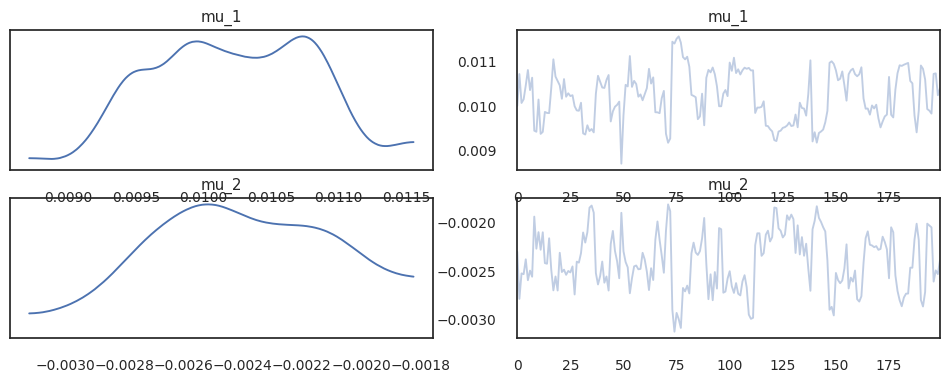

In [183]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [184]:
posterior_samples

{'mu_1': tensor([0.0100, 0.0107, 0.0101, 0.0101, 0.0105, 0.0108, 0.0104, 0.0106, 0.0094,
         0.0094, 0.0101, 0.0094, 0.0094, 0.0099, 0.0098, 0.0098, 0.0104, 0.0110,
         0.0107, 0.0106, 0.0105, 0.0102, 0.0106, 0.0102, 0.0103, 0.0102, 0.0102,
         0.0100, 0.0099, 0.0099, 0.0101, 0.0094, 0.0094, 0.0096, 0.0094, 0.0095,
         0.0094, 0.0103, 0.0107, 0.0105, 0.0104, 0.0104, 0.0106, 0.0107, 0.0097,
         0.0099, 0.0100, 0.0100, 0.0101, 0.0087, 0.0098, 0.0105, 0.0104, 0.0111,
         0.0104, 0.0106, 0.0105, 0.0102, 0.0103, 0.0101, 0.0103, 0.0104, 0.0108,
         0.0105, 0.0106, 0.0099, 0.0099, 0.0098, 0.0102, 0.0103, 0.0094, 0.0092,
         0.0093, 0.0114, 0.0114, 0.0115, 0.0116, 0.0114, 0.0111, 0.0110, 0.0111,
         0.0109, 0.0102, 0.0102, 0.0102, 0.0097, 0.0098, 0.0103, 0.0096, 0.0106,
         0.0108, 0.0108, 0.0109, 0.0107, 0.0104, 0.0100, 0.0100, 0.0103, 0.0104,
         0.0102, 0.0110, 0.0108, 0.0111, 0.0107, 0.0108, 0.0107, 0.0108, 0.0109,
         0.0108, 0.0

In [185]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data1":
        mean = values.mean(dim=0)
        cov = np.cov(values.detach().numpy(), rowvar=False)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov)
    elif key == "sample_data2":
        mean = values.mean(dim=0)
        cov = np.cov(values.detach().numpy(), rowvar=False)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov)
    elif key == "sample_data3":
        mean = values.mean(dim=0)
        cov = np.cov(values.detach().numpy(), rowvar=False)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov)
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

mu_1
mean
 tensor(0.0102, dtype=torch.float64) 
std
 tensor(0.0006, dtype=torch.float64)
mu_2
mean
 tensor(-0.0024, dtype=torch.float64) 
std
 tensor(0.0003, dtype=torch.float64)


In [186]:
# # Create a grid of points
# x, y = np.meshgrid(np.linspace(-0.9, -0.7, 100), np.linspace(-0.2, 1.2, 100))
# pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
# for i in range(3):
#     # Create a multivariate normal distribution
#     rv = multivariate_normal(loc_mean_posterior[i], loc_cov_posterior[i])

#     # Calculate PDF values for each point in the grid
#     pdf_values = rv.pdf(pos)

#     # Plot the Gaussian distribution using contour plot
#     plt.figure(figsize=(8, 6))
#     plt.contourf(x, y, pdf_values, cmap='viridis')
#     plt.colorbar(label='Probability Density')
#     plt.xlabel('spatial')
#     plt.ylabel('spectral')
#     plt.title('2D Gaussian Distribution')
#     plt.scatter(loc_mean_posterior[i][0], loc_mean_posterior[i][1], color='red', label='Mean')
#     plt.legend()
#     plt.grid(True)
# plt.show()

In [187]:
# plt.figure(figsize=(8, 6))
# # Create a grid of points
# x, y = np.meshgrid(np.linspace(-0.9, -0.7, 1000), np.linspace(-2, 2, 1000))
# pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
# for i in range(3):
#     # Calculate distances from the mean for all points in the grid
#     #distances = np.sqrt((x - loc_mean_posterior[i][0])**2 + (y - loc_mean_posterior[i][1])**2)
#     # Create a multivariate normal distribution
#     rv = multivariate_normal(loc_mean_posterior[i], loc_cov_posterior[i])
#     # Calculate PDF values for each point in the grid
#     pdf_values = rv.pdf(pos)
    
   
#     #pdf_values[distances >0.01]=0
#     # Plot the Gaussian distribution using contour plot
#     plt.contour(x, y, pdf_values, extend='min', cmap='viridis')
#     plt.scatter(loc_mean_posterior[i][0], loc_mean_posterior[i][1], label='Mean'+str(i+1))
# #plt.colorbar(label='Probability Density')
# plt.xlabel('spatial')
# plt.ylabel('spectral')
# plt.title('2D Gaussian Distribution')

# plt.legend()
# plt.grid(True)
# plt.show()

In [188]:
data.posterior

<xarray.Dataset> Size: 5kB
Dimensions:  (chain: 1, draw: 200)
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 2kB 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
Data variables:
    mu_1     (chain, draw) float64 2kB 0.01 0.01071 0.01007 ... 0.01024 0.0104
    mu_2     (chain, draw) float64 2kB -0.002305 -0.002787 ... -0.002393
Attributes:
    created_at:                 2024-07-14T20:23:43.610820+00:00
    arviz_version:              0.18.0
    inference_library:          pyro
    inference_library_version:  1.9.0

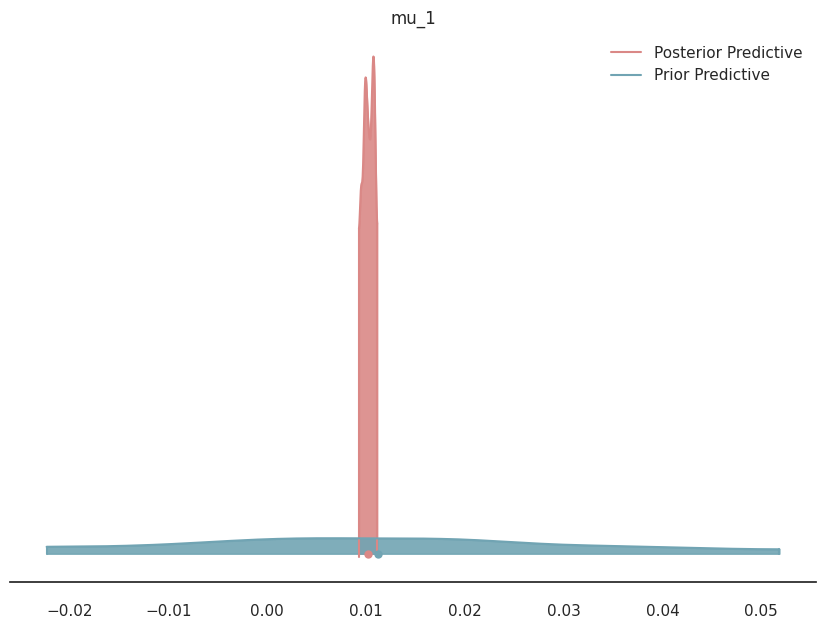

In [189]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

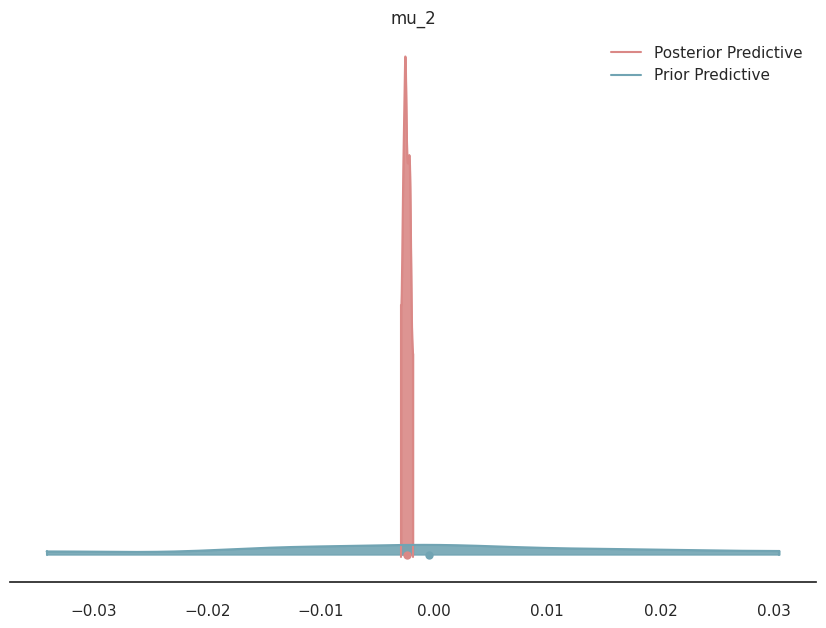

In [190]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

Condition number: 51855.20628572859.


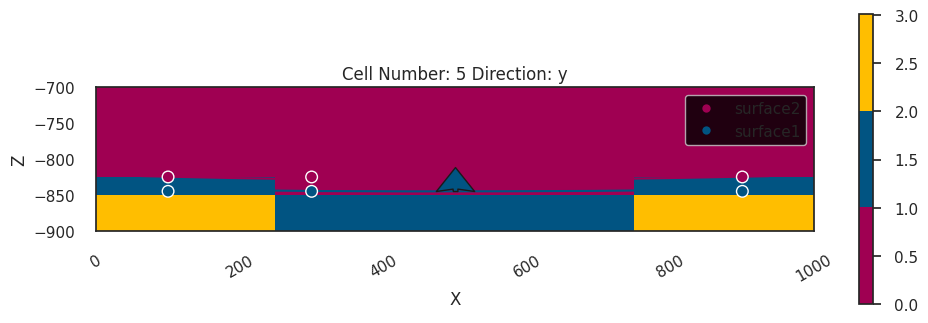

In [191]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([2]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([5]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)
# Compute and observe the thickness of the geological layer
        
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
# accuracy_intermediate = torch.sum(torch.round(custom_grid_values) == y_obs_label) / y_obs_label.shape[0]
# store_accuracy.append(accuracy_intermediate)
lambda_ = 20.0
# loc_mean = torch.tensor(mean_init,dtype=torch.float64)
# loc_cov =  torch.tensor(cov_init, dtype=torch.float64)
z_nk = F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
#class_label = torch.mean(F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1),dim=0)

N_k = torch.sum(z_nk,axis=0)
N = len(custom_grid_values)
pi_k = N_k /N
mean = []
cov = []
for i in range(z_nk.shape[1]):
    mean_k = torch.sum( z_nk[:,i][:,None] * y_obs_label, axis=0)/ N_k[i]
    #cov_k = torch.sum( (normalised_hsi - mean_k.reshape((-1,1))) (normalised_hsi - mean_k).T )
    cov_k = torch.zeros((mean_k.shape[0],mean_k.shape[0]),dtype=torch.float64)
    for j in range(z_nk.shape[0]):
            cov_k +=  z_nk[j,i]* torch.matmul((y_obs_label[j,:] - mean_k).reshape((-1,1)) ,(y_obs_label[j,:] - mean_k).reshape((1,-1)))
    mean.append(mean_k)
    cov_k=cov_k/N_k[i] #+ 1e-3 * torch.diag(torch.ones(cov_k.shape[0],dtype=torch.float64))
    cov.append(cov_k)
mean_tensor = torch.stack(mean, dim=0)
cov_tensor = torch.stack(cov,dim=0)
    
gpv.plot_2d(geo_model_test, cell_number=5,legend='force')

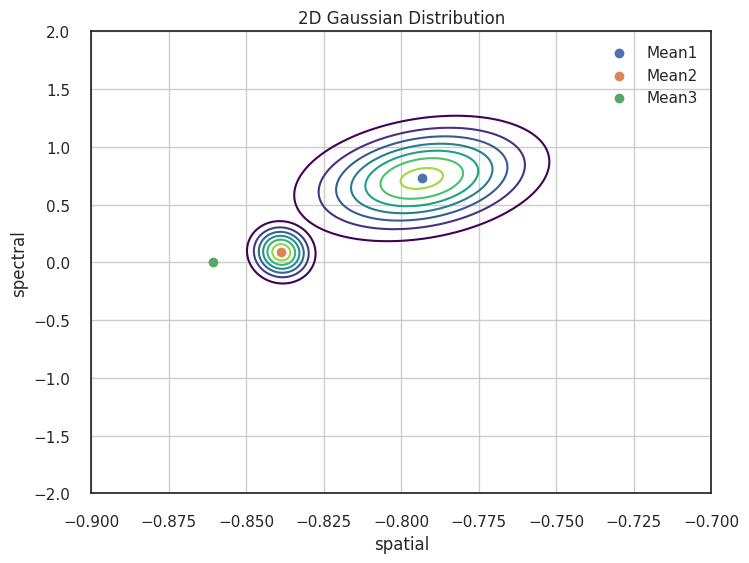

In [192]:
plt.figure(figsize=(8, 6))
# Create a grid of points
x, y = np.meshgrid(np.linspace(-0.9, -0.7, 1000), np.linspace(-2, 2, 1000))
pos = np.dstack((x, y))  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Calculate distances from the mean for all points in the grid
    #distances = np.sqrt((x - loc_mean_posterior[i][0])**2 + (y - loc_mean_posterior[i][1])**2)
    # Create a multivariate normal distribution
    rv = multivariate_normal(mean_tensor.detach().numpy()[i], cov_tensor.detach().numpy()[i])
    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(pos)
    
   
    #pdf_values[distances >0.01]=0
    # Plot the Gaussian distribution using contour plot
    plt.contour(x, y, pdf_values, extend='min', cmap='viridis')
    plt.scatter(mean_tensor.detach().numpy()[i][0], mean_tensor.detach().numpy()[i][1], label='Mean'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('spatial')
plt.ylabel('spectral')
plt.title('2D Gaussian Distribution')

plt.legend()
plt.grid(True)
plt.show()

In [193]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

tensor([[-0.2500,  0.0000,  0.0125],
        [ 0.2500,  0.0000,  0.0125],
        [-0.1250,  0.0000,  0.0102],
        [-0.2500,  0.0000,  0.0000],
        [ 0.2500,  0.0000,  0.0000],
        [-0.1250,  0.0000, -0.0024]], dtype=torch.float64,
       grad_fn=<IndexPutBackward0>)

In [194]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

array([[ 100.        ,    0.        , -825.        ],
       [ 900.        ,    0.        , -825.        ],
       [ 300.        ,    0.        , -828.65461129],
       [ 100.        ,    0.        , -845.        ],
       [ 900.        ,    0.        , -845.        ],
       [ 300.        ,    0.        , -848.85053361]])

In [195]:
#gpv.plot_3d(geo_model_test)

In [196]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values

tensor([3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000,
        3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 3.0000, 2.9999, 2.9999,
        2.9998, 2.9996, 2.9993, 2.9987, 2.9976, 2.9955, 2.9917, 2.9846, 2.9715,
        2.9480, 2.9068, 2.8387, 2.7353, 2.5974, 2.4422, 2.2975, 2.1846, 2.1079,
        2.0607, 2.0334, 2.0181, 2.0098, 2.0052, 2.0028, 2.0015, 2.0008, 2.0004,
        2.0002, 2.0001, 2.0001, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 1.9999, 1.9999, 1.9998, 1.9996, 1.9992, 1.9985, 1.9971,
        1.9946, 1.9900, 1.9814, 1.9657, 1.9376, 1.8890, 1.8104, 1.6952, 1.5489,
        1.3936, 1.2572, 1.1559, 1.0896, 1.0499, 1.0272, 1.0147, 1.0079, 1.0042,
        1.0023, 1.0012, 1.0006, 1.0003, 1.0002, 1.0001, 1.0001, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(
/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy_engine/core/data/transforms.py:187: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(


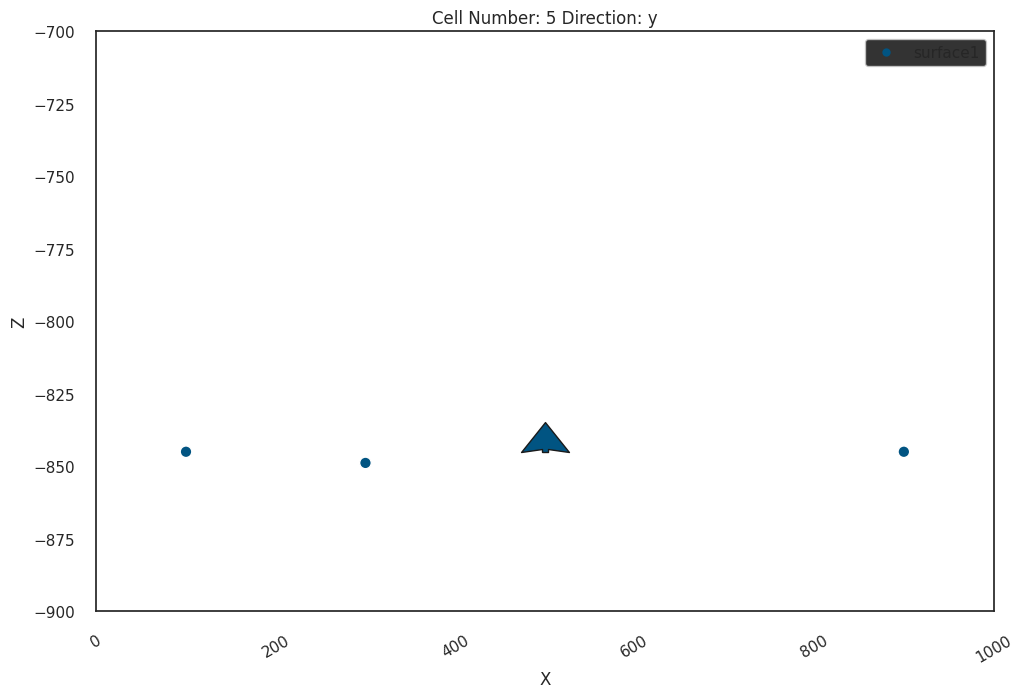

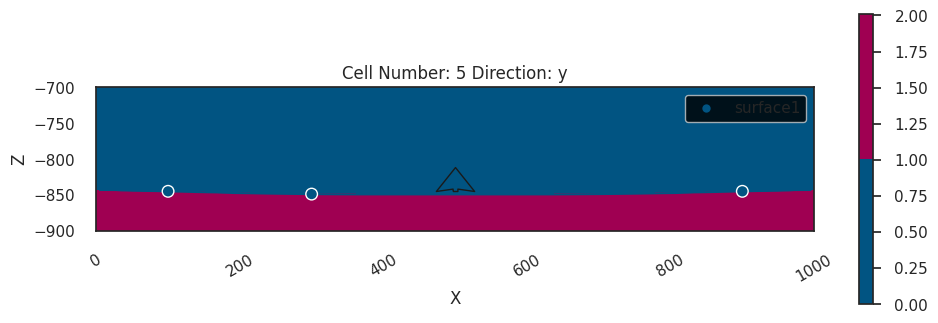

In [205]:
geo_model_post = gp.create_geomodel(
    project_name='Gempy_post_Test',
    extent=[0, 1000, -10, 10, -900, -700],
    resolution=[100,10,100],
    refinement=7,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
geo_model_post.interpolation_options.kernel_options.range=5
gp.add_surface_points(
    geo_model=geo_model_post,
    x=sp_cord[3:,0],
    y=sp_cord[3:,1],
    z=sp_cord[3:,2],
    elements_names=['surface1', 'surface1','surface1']
)
gp.add_orientations(
    geo_model=geo_model_post,
    x=[500],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1.0]]
)
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)  
gp.compute_model(geo_model_post, engine_config=gp.data.GemPyEngineConfig())
gpv.plot_2d(geo_model_post, cell_number=[5])
    

Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_pyro/lib/python3.10/site-packages/gempy_engine/core/data/transforms.py:187: RuntimeWarning: Interpolation is being done with the default transform. If you do not know what you are doing you should probably call GeoModel.update_transform() first.
  warnings.warn(


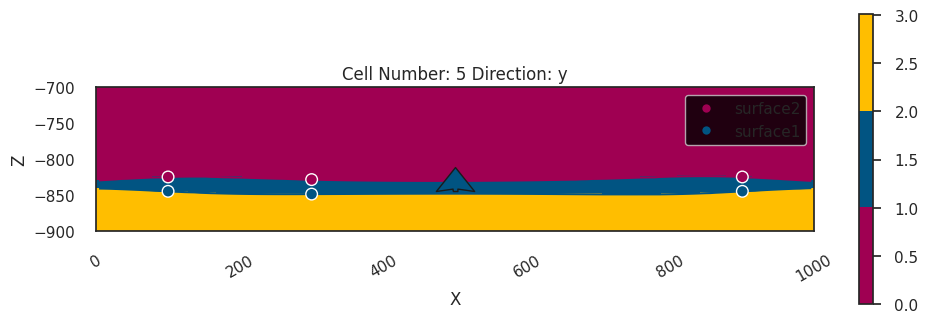

In [206]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=sp_cord[:3,0],
        y=sp_cord[:3,1],
        z=sp_cord[:3,2],
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)
geo_model_post.structural_frame.structural_groups[0].append_element(element2)
gp.compute_model(geo_model_post)
#gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_post.structural_frame.structural_groups[0].elements[0], geo_model_post.structural_frame.structural_groups[0].elements[1] = \
geo_model_post.structural_frame.structural_groups[0].elements[1], geo_model_post.structural_frame.structural_groups[0].elements[0]
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
